# 추석기간내 경기도 확진자수 예측 및 정책제언
<hr>

## [Index]

### 1) Introduction
+ 해외여행 수요 분석
    + 코로나 팬더믹전과 시작된 이후 해외여행 수요 분석 
+ Tmap 데이터를 이용한 국내 여행 검색 건수 분석
    + 코로나 전후로 여행 관련 검색 건수 비교 
   
  
### 2) Analysis
+ 데이터 전처리
    + 확진자 데이터를 이용한 베타, 감마 도출
    + 유동인구 데이터 전처리
    + 검색건수 데이터 전처리
    + 교통량 데이터 전처리
+ 모델링 및 학습
    + 베타 예측
        + GRU 모델을 이용한 시계열 예측
    + 감마 예측
         + LSTM 모델을 이용한 시계열 예측
+ 확진자 수 예측
    + 예측한 베타와 감마를 SIR 모델에 넣어 확진자 수 예측
    

### 3) Results
+ 추석기간내 교통량에 의한 경기도 확진자 수 예측결과  


## [활용 데이터 설명]

+ 해외 출입국 현황 데이터
    + 연간 및 월별 내외국인 공항 및 항구별 출입국자 현황 데이터
    + 링크: https://www.data.go.kr/data/15064433/fileData.do
+ Tmap 교통량 데이터
    + SKT 빅데이터 허브에서 제공하는 데이터로 T map 사용 정보를 기반으로 지역별 인기 목적지 데이터
    + 링크: https://www.bigdatahub.co.kr/product/list.do?menu_id=1000156
+ 지하철 유동인구 데이터
    + 지하철호선별 역별 승하차인원 데이터
    + 링크: https://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do
+ 일일 확진자 수 데이터
    + 대한민국 일일 확진자 현왕 데이터
    + 링크: https://github.com/jooeungen/coronaboard_kr
+ 전국 고속도로 교통량 데이터
    + 전국 출구 기준 교통량 데이터
    + 링크: http://data.ex.co.kr/portal/traffic/trafficRegion
+ 네이버 데이터 랩 검색건수 데이터
    + 네이버 데이터 랩에서 '확진자'에 대한 검색건수 데이터
    + 네이버에서 해당 검색어가 검색된 횟수를 일별/주별/월별 각각 합산하여 조회기간 내 최다 검색량을 100으로 설정하여 상대적인 변화를 나타냄
    + 링크 : https://datalab.naver.com/keyword/trendSearch.naver

+ 사용 version은 다음과 같음
    + tensorflow : 2.1.0
    + jupyter notebook : Anaconda3

# 0) 필요한 Package Import

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import locale
import tensorflow as tf
from locale import atof
from scipy.integrate import odeint
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import Span, HoverTool, CrosshairTool
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from datetime import datetime
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU, SimpleRNN, Bidirectional,Reshape
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)
plt.style.use('ggplot')
np.random.seed(777)
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [2]:
def generateX(a, n):
    x_train=[]
    y_train=[]
    for i in range(len(a)):
        x = a[i:(i + n)]
        if (i + n) < len(a):
            x_train.append(x)
            y_train.append(a[i + n])
        else:
            break
    
    return np.array(x_train), np.array(y_train)


def para_det (total_population, I, R):
    S = total_population - I - R
    
    gamma=[]
    beta=[]

    s_ = S 
    i_ = I 
    r_ = R 
    
    der_i = np.zeros(len(i_))
    der_r = np.zeros(len(r_))
                         
    for day in range(0,len(I)-1):
        der_r[day] = r_[day+1] - r_[day]
    
    for i in range(0, len(I)-1):
        g = der_r[i] / i_[i]
        gamma.append(g) 
        
    for i in range(0, len(I)-1):
        b= ((np.log(i_[i+1]/i_[i]) + gamma[i])*total_population)/s_[i]
        beta.append(b)
    
    return s_, i_, r_, gamma, beta

def liquidpop_month(month):
    if month < 5:
        fname = 'CARD_SUBWAY_MONTH_20200' + str(month) + '.csv'
        pop_month = pd.read_csv(fname, encoding = 'ANSI')
    
    elif month == 5:
        fname = 'CARD_SUBWAY_MONTH_20200' + str(month) + '.csv'
        pop_month = pd.read_csv(fname, encoding = 'UTF-8')
        pop_month['사용일자'] = pop_month.index
        pop_month['등록일자'] = pop_month['하차총승객수']
        pop_month['하차총승객수'] = pop_month['승차총승객수']
        pop_month['승차총승객수'] = pop_month['역명']
        pop_month.drop(columns = ['역명'], inplace = True)    

    else:
        fname = 'CARD_SUBWAY_MONTH_20200' + str(month) + '.csv'
        pop_month = pd.read_csv(fname, encoding = 'UTF-8')
        pop_month['등록일자'] = pop_month['하차총승객수']
        pop_month['하차총승객수'] = pop_month['승차총승객수']
        pop_month['승차총승객수'] = pop_month['역명']
        pop_month['역명'] = pop_month['역ID']
        pop_month.drop(columns = ['역ID'], inplace = True)
        
    monthly_liquid = pop_month[['승차총승객수', '하차총승객수']].groupby(pop_month['사용일자']).sum()
    return monthly_liquid

def embedded_plots(x1, y1, x2, y2, label_x, label_y1, label_y2):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x1, y1, color = 'red')
    ax1.set_xlabel(label_x, fontsize=12)         
    ax1.set_ylabel(label_y1, fontsize=12, color = 'red')     

    ax2.plot(x2, y2, color = 'blue')
    ax2.set_xlabel(label_x, fontsize=12)          
    ax2.set_ylabel(label_y2, fontsize=12, color = 'blue')    

    fig.tight_layout()

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def plot_loss(epochs, mae):
    #------------------------------------------------
    # Plot MAE and Loss
    #------------------------------------------------
    plt.plot(epochs, mae, 'r')
    plt.title('MAE')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.figure()

    epochs_zoom = epochs[200:]
    mae_zoom = mae[200:]

    #------------------------------------------------
    # Plot Zoomed MAE and Loss
    #------------------------------------------------
    plt.plot(epochs_zoom, mae_zoom, 'r')
    plt.title('MAE')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["MAE", "Loss"])
    plt.figure()

def windowing(data, window_size, test_size):
    histories = np.zeros((data.shape[0]-window_size, window_size, data.shape[1]))
    results = np.zeros((data.shape[0]-window_size, 1, data.shape[1]))
    for i in range((data.shape[0]-window_size)):
        result = data.iloc[i+window_size, :].to_numpy()
        result = result.reshape((1, 1, data.shape[1]))
        results[i] = result
        history = data.iloc[i:i+window_size, :].to_numpy()
        history = history.reshape((1, window_size, data.shape[1]))
        histories[i] = history
    X_train = histories[:-test_size, :, :]
    X_test = histories[-test_size:, :, :]
    y_train = results[:-test_size, :, :]
    y_test = results[-test_size:, :, :]
    return X_train, X_test, y_train, y_test

def scheduling(model, X, y, epoch, batch_size):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-6 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer=optimizer,
                  metrics=["mse"])
    history = model.fit(X, y, epochs = epoch, batch_size = batch_size, callbacks=[lr_schedule], verbose=0)

    plt.semilogx(history.history["lr"], history.history["loss"])

def scheduled_train(model, X_train, y_train, epoch, batch_size, lr):
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer=optimizer,
                  metrics=["mse"])
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size)

def predplot(y_test_df, y_naive, y_hat, feature_size):  
    fig, axes = plt.subplots(nrows = feature_size, ncols = 1, figsize = (13, 6), dpi = 300)
    for i in range(feature_size):
        if feature_size == 1:
            axes.plot(y_test_df.index, y_test_df.iloc[:,i], label = 'Real')
            axes.plot(y_naive.index, y_naive.iloc[:,i], '--', label = 'Naive')
            axes.plot(y_hat.index, y_hat.iloc[:,i], '--',label = 'Predict')
            axes.legend(loc = 'upper left')
            axes.set_ylabel(y_hat.columns[i], fontsize = 15)        
        else:
            axes[i].plot(y_test_df.index, y_test_df.iloc[:,i], label = 'Real')
            axes[i].plot(y_naive.index, y_naive.iloc[:,i], '--', label = 'Naive')
            axes[i].plot(y_hat.index, y_hat.iloc[:,i], '--',label = 'Predict')
            axes[i].legend(loc = 'upper left')
            axes[i].set_ylabel(y_hat.columns[i], fontsize = 15)

def future_pred(data, window_size, feature_size, days_to_predict, y_hat, model):
    latest_history = data.iloc[-window_size:, :]
    latest_history.index = range(window_size)
    days_to_predict = days_to_predict
    future = pd.DataFrame(columns = data.columns)

    for i in range(len(y_hat.index), len(y_hat.index)+days_to_predict):
        x_lat = latest_history.to_numpy()
        x_lat = x_lat.reshape((1, window_size, feature_size))
        y_fut = model.predict(x_lat)
        y_fut = y_fut.reshape(1, feature_size)
        y_fut2 = pd.DataFrame(y_fut, index = [i], columns = data.columns)
        future = pd.concat([future, y_fut2], axis = 0)
        latest_history.drop(index = 0, axis = 0, inplace = True)
        latest_history = pd.concat([latest_history, y_fut2], axis = 0)
        latest_history.index = range(window_size)

    y_hat = pd.concat([y_hat,future], axis = 0)
    return y_hat

def error_mat(y_test_df, y_naive, y_hat):
    error_matrix = pd.DataFrame(columns = y_hat.columns, index = ['naive', 'predicted'], data = 0)

    for feature in error_matrix.columns:
        error_matrix.loc['naive', feature] = tf.keras.metrics.mean_squared_error(y_test_df[feature], y_naive[feature]).numpy()
        error_matrix.loc['predicted', feature] = tf.keras.metrics.mean_squared_error(y_test_df[feature], y_hat[feature]).numpy()
    print(error_matrix)
    
def windowing_v2(data, start_date, end_date, target, window_size, test_size):
    data_scope = data.loc[start_date:end_date]
    label = pd.DataFrame(data[target])
    histories = np.zeros((data_scope.shape[0]-window_size, window_size, data_scope.shape[1]))
    results = np.zeros((data_scope.shape[0]-window_size, 1, label.shape[1]))

    for i in range((data_scope.shape[0]-window_size)):
        result = pd.DataFrame(label.iloc[i+window_size]).to_numpy()
        result = result.reshape((1, 1, result.shape[1]))
        results[i] = result
        history = data_scope.iloc[i:i+window_size, :].to_numpy()
        history = history.reshape((1, window_size, data_scope.shape[1]))
        histories[i] = history
    X_train = histories[:-test_size, :, :]
    X_test = histories[-test_size:, :, :]
    y_train = results[:-test_size, :, :]
    y_test = results[-test_size:, :, :]
    return X_train, X_test, y_train, y_test

def windowing_v3(data, start_date, end_date, target, window_size, test_size):
    data_scope = data.loc[start_date:end_date]
    histories = np.zeros((data_scope.shape[0]-window_size, window_size, data_scope.shape[1]))
    results = np.zeros((data_scope.shape[0]-window_size, 1, data_scope.shape[1]))

    for i in range((data_scope.shape[0]-window_size)):
        result = pd.DataFrame(data_scope.iloc[i+window_size]).to_numpy()
        result = result.reshape((1, 1, data_scope.shape[1]))
        results[i] = result
        history = data_scope.iloc[i:i+window_size, :].to_numpy()
        history = history.reshape((1, window_size, data_scope.shape[1]))
        histories[i] = history
    X_train = histories[:-test_size, :, :]
    X_test = histories[-test_size:, :, :]
    y_train = results[:-test_size, :, :]
    y_test = results[-test_size:, :, :]
    return X_train, X_test, y_train, y_test

def plot_IR(
    name=None, t=None, i_actual=None, r_actual=None, i_pred=None, r_pred=None,
    t_fit=None
):
    p = figure(title=name, x_axis_type="datetime", plot_height=400, plot_width=800)

    # plot data
    src = ColumnDataSource(data={
        'dt': t,
        'i_actual': i_actual if i_actual is not None else np.full(len(t), np.nan),
        'r_actual': r_actual if r_actual is not None else np.full(len(t), np.nan),
        'i_pred': i_pred if i_pred is not None else np.full(len(t), np.nan),
        'r_pred': r_pred if r_pred is not None else np.full(len(t), np.nan)
    })
    if i_actual is not None:
        ls = p.line('dt', 'i_actual', source=src, color='blue', alpha=0.3, legend_label='Infected (actual)')
        p.add_tools(HoverTool(renderers=[ls], tooltips=[('i_actual', '@i_actual{0,0}')], mode='vline'))
    if r_actual is not None:
        li = p.line('dt', 'r_actual', source=src, color='red', alpha=0.3, legend_label='recovered (actual)')
        p.add_tools(HoverTool(renderers=[li], tooltips=[('r_actual', '@r_actual{0,0}')], mode='vline'))
    if i_pred is not None:
        lr = p.line('dt', 'i_pred', source=src, color='green', alpha=0.3, legend_label='Infected (predicted)')
        p.add_tools(HoverTool(renderers=[lr], tooltips=[('i_pred', '@i_pred{0,0}')], mode='vline'))
    if r_pred is not None:
        lt = p.line('dt', 'r_pred', source=src, color='orange', alpha=0.3, legend_label='Recovered (predicted)')
        p.add_tools(HoverTool(renderers=[lt], tooltips=[('r_pred', '@r_pred{0,0}')], mode='vline'))

    p.add_tools(CrosshairTool(dimensions='height', line_alpha=0.3))
    p.legend.location = "top_left"
    if t_fit is not None and t_pred is not None:
        t_cutoff = t_fit[-1] + (t_pred[0] - t_fit[-1]) / 2.0
        p.add_layout(
            Span(location=t_cutoff, dimension='height', line_color='gray', line_dash='dotted')
        )
    show(p)
    
    
    
def plot_total_case(
    name=None, t=None, total_actual=None, total_pred=None,
    t_fit=None, s_fit=None, i_fit=None, r_fit=None,
    t_pred=None, s_pred=None, i_pred=None, r_pred=None
):
    p = figure(title=name, x_axis_type="datetime", plot_height=400, plot_width=800)

    # plot data
    src = ColumnDataSource(data={
        'dt': t,
        'total_actual': total_actual if total_actual is not None else np.full(len(t), np.nan),
        'total_pred': total_pred if total_pred is not None else np.full(len(t), np.nan)
    })
    if total_actual is not None:
        ls = p.line('dt', 'total_actual', source=src, color='red', alpha=0.3, legend_label='total_infected (actual)')
        p.add_tools(HoverTool(renderers=[ls], tooltips=[('total_actual', '@total_actual{0,0}')], mode='vline'))
    if total_pred is not None:
        lp = p.line('dt', 'total_pred', source=src, color='blue', alpha=0.3, legend_label='total_infected (predicted)')
        p.add_tools(HoverTool(renderers=[lp], tooltips=[('total_pred', '@total_pred{0,0}')], mode='vline'))

    p.add_tools(CrosshairTool(dimensions='height', line_alpha=0.3))
    p.legend.location = "top_left"
    if t_fit is not None and t_pred is not None:
        t_cutoff = t_fit[-1] + (t_pred[0] - t_fit[-1]) / 2.0
        p.add_layout(
            Span(location=t_cutoff, dimension='height', line_color='gray', line_dash='dotted')
        )
    show(p)

# 1) Introduction

### A) 해외여행 수요 급감

In [3]:
travel_overseas_2019=pd.read_csv('2019년월별 내외국인 출입국자현황(20191231기준).csv', encoding='CP949')
travel_overseas_2020=pd.read_csv('법무부_내외국인 출입국자현황_20200630.csv', encoding='CP949')

In [4]:
travel_overseas_2019

,구분,공항만,인천공항,김해공항,김포공항,대구공항,제주공항,부 산 항,인 천 항,무안공항,평 택 항,청주공항,군 산 항,울 산 항,여 수 항,감 천 항,광 양 항,기 타
0,1월 입국,국민,2063832,409026,101282,132266,16530,61385,5862,35601,3776,24625,2699,2443,1044,268,1050,8231
1,1월 입국,외국인,763383,81364,80525,9635,70567,24111,35281,690,23902,6285,13320,3506,2561,4687,3256,10342
2,1월 출국,국민,2128663,406250,102512,132314,15705,60586,5452,35844,3446,25210,2076,2215,1108,261,1369,7207
3,1월 출국,외국인,897827,95865,89246,11514,70716,24892,45630,1113,24153,7002,13430,4409,2641,4988,2929,10781
4,2월 입국,국민,1893157,357254,92072,116893,14802,62404,3680,33714,1818,18275,903,2002,1052,223,999,4471
5,2월 입국,외국인,866003,101405,84089,12213,79751,18251,29692,1160,15049,8330,6126,3348,1934,3423,2816,11914
6,2월 출국,국민,1898306,367782,97481,118407,16715,64764,3521,34426,1809,18551,1172,1977,1206,185,1141,3980
7,2월 출국,외국인,765065,85895,77686,10176,77931,17235,26372,1059,14244,7507,5910,3524,1991,4094,2374,10257
8,3월 입국,국민,1802488,350038,95083,108459,13914,58969,5362,28000,3730,15309,2326,2265,1314,332,1108,4572
9,3월 입국,외국인,1061224,129396,108407,18527,87305,31320,53076,1591,26406,7542,14231,3283,2261,3761,3317,18068


In [5]:
travel_overseas_2020

,구분,공항만,인천공항,김해공항,김포공항,대구공항,제주공항,부 산 항,인 천 항,무안공항,평 택 항,청주공항,군 산 항,울 산 항,여 수 항,감 천 항,광 양 항,기 타
0,1월 입국,국민,1952750,347923,88098,82494,13201,17575,3698,34505,3247,16153,1981,2251,1068,544,833,4624
1,1월 입국,외국인,932991,90679,83182,12677,103367,17072,22717,867,18863,4553,9419,2906,1738,4412,1962,12606
2,1월 출국,국민,1931298,334164,82619,78284,11670,19035,3350,33379,2680,15778,1144,1825,949,339,1204,4355
3,1월 출국,외국인,1018065,97736,90917,13792,108643,10428,28714,922,18329,4796,9598,1458,1469,2673,1860,10491
4,2월 입국,국민,1058416,138540,38025,25238,3656,11902,1422,11691,569,3744,105,2063,1262,404,665,3423
5,2월 입국,외국인,545432,60230,62486,6842,14110,9139,1339,399,400,1195,380,1942,1798,3093,523,10141
6,2월 출국,국민,850017,113079,38334,19278,2963,11653,1366,8605,356,2579,85,1717,1098,384,1058,2997
7,2월 출국,외국인,580748,65450,67294,7462,20124,8284,1360,461,260,843,363,1602,1680,1972,680,9127
8,3월 입국,국민,239532,12020,3832,0,163,4581,1314,121,765,0,169,2293,1272,455,697,2628
9,3월 입국,외국인,73042,3655,2835,0,516,2179,507,9,169,0,123,878,869,2584,172,3299


+ 코로나로 인한 해외여행 수요의 변화를 보기 위해 19년 1월부터 20년 6월까지의 인천공항에서의 출국현황을 보도록 하겠습니다

In [6]:
travel_overseas_2019=travel_overseas_2019[(travel_overseas_2019['공항만']=='국민')].reset_index().drop(['index'], axis=1)
travel_overseas_2019=travel_overseas_2019.drop(['김해공항','김포공항','대구공항','제주공항','부 산 항','인 천 항','무안공항','평 택 항','청주공항','군 산 항','울 산 항','여 수 항','감 천 항','광 양 항','기  타'], axis=1)
for i in range(0, 24, 2):
    travel_overseas_2019=travel_overseas_2019.drop([i])
    
travel_overseas_2020=travel_overseas_2020[(travel_overseas_2020['공항만']=='국민')].reset_index().drop(['index'], axis=1)
travel_overseas_2020=travel_overseas_2020.drop(['김해공항','김포공항','대구공항','제주공항','부 산 항','인 천 항','무안공항','평 택 항','청주공항','군 산 항','울 산 항','여 수 항','감 천 항','광 양 항','기  타'], axis=1)
for i in range(0, 12, 2):
    travel_overseas_2020=travel_overseas_2020.drop([i])

In [7]:
travel_overseas_2019

,구분,공항만,인천공항
1,1월 출국,국민,2128663
3,2월 출국,국민,1898306
5,3월 출국,국민,1695276
7,4월 출국,국민,1635607
9,5월 출국,국민,1754693
11,6월 출국,국민,1843291
13,7월 출국,국민,1979070
15,8월 출국,국민,1840423
17,9월 출국,국민,1596011
19,10월 출국,국민,1659303


In [8]:
travel_overseas_2020

,구분,공항만,인천공항
1,1월 출국,국민,1931298
3,2월 출국,국민,850017
5,3월 출국,국민,116655
7,4월 출국,국민,19289
9,5월 출국,국민,24796
11,6월 출국,국민,36315


In [9]:
travel_total=pd.concat([travel_overseas_2019, travel_overseas_2020]).reset_index(drop=True)
travel_overseas_range=pd.date_range('2019-01', periods=18, freq='MS')
travel_total=travel_total.set_index(travel_overseas_range).drop(['구분', '공항만'], axis=1)
travel_total

,인천공항
2019-01-01,2128663
2019-02-01,1898306
2019-03-01,1695276
2019-04-01,1635607
2019-05-01,1754693
2019-06-01,1843291
2019-07-01,1979070
2019-08-01,1840423
2019-09-01,1596011
2019-10-01,1659303


Text(0, 0.5, '출국인원')

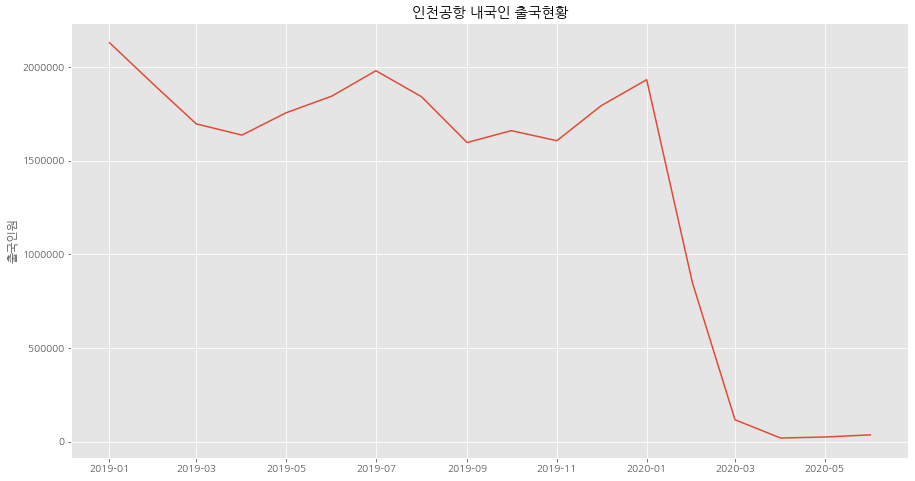

In [10]:
plt.figure(figsize=(15, 8))
plt.title('인천공항 내국인 출국현황')
ax=sns.lineplot(data=travel_total, x=travel_total.index, y='인천공항')
ax.set_ylabel('출국인원')

+ 20년 2월 코로나 사태 이후 인천공항에서의 해외 출국 수요가 급감했음을 확인할 수 있다

### B) Tmap 데이터를 이용한 여행지역 검색건수 분석

+ 먼저 코로나 사태 이전과 비교를 위해 19년 데이터와 20년 데이터를 불러와 데이터 전처리를 해보자

In [11]:
tmap_19_02=pd.read_csv('TMAP_USE_02MONTH.csv')
tmap_19_03=pd.read_csv('TMAP_USE_03MONTH.csv')
tmap_19_04=pd.read_csv('TMAP_USE_04MONTH.csv')
tmap_19_05=pd.read_csv('TMAP_USE_05MONTH.csv')
tmap_19_06=pd.read_csv('TMAP_USE_06MONTH.csv')
tmap_19_07=pd.read_csv('TMAP_USE_07MONTH.csv')
tmap_19_08=pd.read_csv('TMAP_USE_08MONTH.csv')

In [12]:
tmap_19_02=tmap_19_02.groupby(['검색지유형1'], as_index=False).count()
tmap_19_02=tmap_19_02.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_02=tmap_19_02.rename(columns={'일자': '2월'})

tmap_19_03=tmap_19_03.groupby(['검색지유형1'], as_index=False).count()
tmap_19_03=tmap_19_03.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_03=tmap_19_03.drop([9], axis=0).reset_index(drop=True)
tmap_19_03=tmap_19_03.rename(columns={'일자': '3월'})

tmap_19_04=tmap_19_04.groupby(['검색지유형1'], as_index=False).count()
tmap_19_04=tmap_19_04.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_04=tmap_19_04.rename(columns={'일자': '4월'})

tmap_19_05=tmap_19_05.groupby(['검색지유형1'], as_index=False).count()
tmap_19_05=tmap_19_05.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_05=tmap_19_05.rename(columns={'일자': '5월'})

tmap_19_06=tmap_19_06.groupby(['검색지유형1'], as_index=False).count()
tmap_19_06=tmap_19_06.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_06=tmap_19_06.drop([9], axis=0).reset_index(drop=True)
tmap_19_06=tmap_19_06.rename(columns={'일자': '6월'})

tmap_19_07=tmap_19_07.groupby(['검색지유형1'], as_index=False).count()
tmap_19_07=tmap_19_07.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_07=tmap_19_07.drop([9], axis=0).reset_index(drop=True)
tmap_19_07=tmap_19_07.rename(columns={'일자': '7월'})

tmap_19_08=tmap_19_08.groupby(['검색지유형1'], as_index=False).count()
tmap_19_08=tmap_19_08.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_19_08=tmap_19_08.rename(columns={'일자': '8월'})

In [13]:
tmap_19=pd.concat([tmap_19_02, tmap_19_03,tmap_19_04,tmap_19_05,tmap_19_06,tmap_19_07, tmap_19_08], axis=1)
tmap_19=tmap_19.set_index('검색지유형1')
tmap_19=tmap_19.T
tmap_19

검색지유형1,AOI,건물/시설,공공편의,교통편의,그룹핑부속,금융편의,기업/단체,생활편의,쇼핑,여행/레저,의료편의
2월,2853,49069,20963,30175,296,399,4691,36687,19740,36814,8313
3월,3084,50375,23638,32961,387,443,5807,40225,21897,44366,9314
4월,2649,46373,22174,32201,396,387,5669,38233,20553,47332,9032
5월,2622,48359,22088,32829,423,396,5308,39952,21367,50374,8780
6월,2384,47119,20350,30912,430,349,5155,40437,20619,48962,8282
7월,2621,50219,20291,31272,478,362,5613,41080,21730,50037,8794
8월,2498,49399,18893,31156,537,277,4607,44012,21865,51491,7762


In [14]:
tmap_20_02=pd.read_csv('Tmap_2002.csv')
tmap_20_03=pd.read_csv('Tmap_2003.csv')
tmap_20_04=pd.read_csv('Tmap_2004.csv')
tmap_20_05=pd.read_csv('Tmap_2005.csv')
tmap_20_06=pd.read_csv('Tmap_2006.csv')
tmap_20_07=pd.read_csv('Tmap_2007.csv')
tmap_20_08=pd.read_csv('Tmap_2008.csv')

In [15]:
tmap_20_02=tmap_20_02.groupby(['검색지유형1'], as_index=False).count()
tmap_20_02=tmap_20_02.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_02=tmap_20_02.rename(columns={'일자': '2월'})

tmap_20_03=tmap_20_03.groupby(['검색지유형1'], as_index=False).count()
tmap_20_03=tmap_20_03.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_03=tmap_20_03.rename(columns={'일자': '3월'})

tmap_20_04=tmap_20_04.groupby(['검색지유형1'], as_index=False).count()
tmap_20_04=tmap_20_04.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_04=tmap_20_04.rename(columns={'일자': '4월'})

tmap_20_05=tmap_20_05.groupby(['검색지유형1'], as_index=False).count()
tmap_20_05=tmap_20_05.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_05=tmap_20_05.rename(columns={'일자': '5월'})

tmap_20_06=tmap_20_06.groupby(['검색지유형1'], as_index=False).count()
tmap_20_06=tmap_20_06.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_06=tmap_20_06.rename(columns={'일자': '6월'})

tmap_20_07=tmap_20_07.groupby(['검색지유형1'], as_index=False).count()
tmap_20_07=tmap_20_07.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_07=tmap_20_07.rename(columns={'일자': '7월'})
tmap_20_07.iloc[10, 0]=tmap_20_07.iloc[10, 0]+tmap_20_07.iloc[12, 0]+tmap_20_07.iloc[13, 0]
tmap_20_07=tmap_20_07.drop([1, 12, 13], axis=0).reset_index(drop=True)


tmap_20_08=tmap_20_08.groupby(['검색지유형1'], as_index=False).count()
tmap_20_08=tmap_20_08.drop(['지역(시도)','지역(시군구)','검색지명','검색지유형1','검색지유형2','검색지유형3','검색지랭킹(시군구내)'], axis=1)
tmap_20_08=tmap_20_08.rename(columns={'일자': '8월'})
tmap_20_08.iloc[10, 0]=tmap_20_08.iloc[10, 0]+tmap_20_08.iloc[12, 0]+tmap_20_08.iloc[13, 0]
tmap_20_08=tmap_20_08.drop([1, 12, 13], axis=0).reset_index(drop=True)

In [16]:
tmap_20=pd.concat([tmap_20_02, tmap_20_03,tmap_20_04,tmap_20_05,tmap_20_06,tmap_20_07, tmap_20_08], axis=1)
tmap_20=tmap_20.set_index('검색지유형1')
tmap_20=tmap_20.T
tmap_20

검색지유형1,AOI,건물/시설,공공편의,교통편의,그룹핑부속,금융편의,기업/단체,생활편의,쇼핑,여행/레저,의료편의
2월,2180,54885,21158,28378,430,463,5984,38365,20370,36386,8890
3월,3255,63952,21718,29502,326,504,6414,34214,21203,42983,8429
4월,2168,63310,20410,28598,402,438,5408,32053,21319,43055,7839
5월,1013,66459,21121,29037,540,395,5040,33955,22608,44487,7845
6월,861,64447,21855,27900,436,379,5697,30672,21630,42942,8181
7월,1041,73803,19943,26500,261,317,6819,24264,20145,49064,9873
8월,1134,75857,18227,25892,238,261,5786,22679,20541,51689,9650


In [17]:
total_tmap=pd.DataFrame(columns=['여행/레저_19년', '여행/레저_20년', '건물/시설_19년', '건물/시설_20년'])
total_tmap['여행/레저_19년']=tmap_19['여행/레저']
total_tmap['여행/레저_20년']=tmap_20['여행/레저']
total_tmap['건물/시설_19년']=tmap_19['건물/시설']
total_tmap['건물/시설_20년']=tmap_20['건물/시설']

total_tmap

,여행/레저_19년,여행/레저_20년,건물/시설_19년,건물/시설_20년
2월,36814,36386,49069,54885
3월,44366,42983,50375,63952
4월,47332,43055,46373,63310
5월,50374,44487,48359,66459
6월,48962,42942,47119,64447
7월,50037,49064,50219,73803
8월,51491,51689,49399,75857


Text(0, 0.5, '검색 건수')

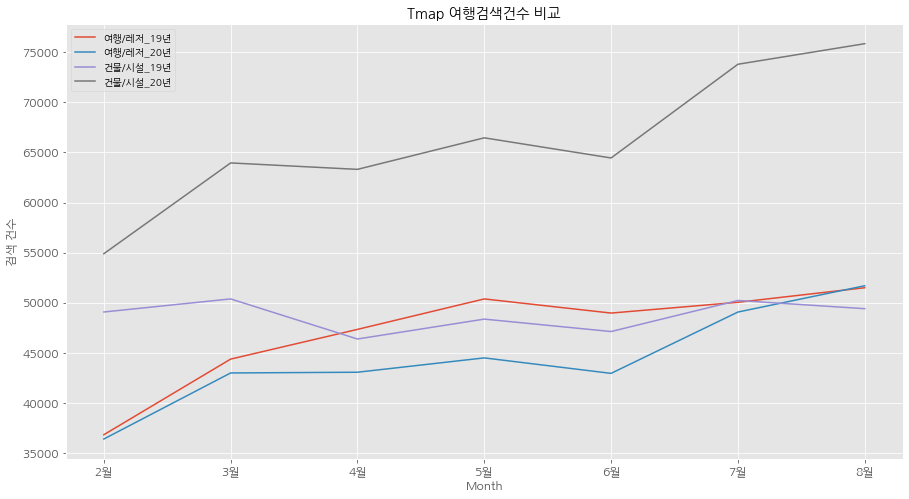

In [18]:
ax = total_tmap[['여행/레저_19년','여행/레저_20년','건물/시설_19년','건물/시설_20년']].plot(kind='line', title='Tmap 여행검색건수 비교', figsize=(15, 8), legend=True, fontsize=12)
ax.set_xlabel('Month', fontsize=12)  
ax.set_ylabel('검색 건수', fontsize=12) 

+ 코로나로 인해 건물/시설등을 방문할 때에는 대중교통보다 자차를 이용하는 것으로 보임
+ 그에 비해 코로나 확산세와 무관하게 여행/레저는 코로나 전과는 큰차이가 없는 것으로 보임
+ 특히 연휴기간 해외여행 급감으로 인해 여행 수요가 국내로 몰릴것으로 예상


*즉 코로나 확산세와 상관없이 이번 추석에 국내 여행 수요가 많을 것으로 예상됨*
+ 늘어난 여행 수요로 방역사각지대인 휴게소에서의 전파를 통한 확진자를 예측해보고 감염을 줄일수 있는 정책을 제시

* * * * * 

# 2) Analysis

확진자 예측을 위해 SIR 모델을 사용


### SIR Model in Mathematical Equation
SIR Model은 확진 가능성이 있는 사람 혹은 연약계층(S, Suceptible), 확진자(I, Infectiuos), 회복 혹은 사망자(R, Recovery)의 관계를 엮은 전염병 예측에서 가장 흔히 사용되는 모델이다. 이들의 관계는 아래 수식과 같이 표현될 수 있음. 

\begin{align}
\dot{s(t)} & = -\beta(t)s(t)i(t) \\
\dot{i(t)} & = \beta(t)s(t)i(t) - \gamma i(t) \\
\dot{r(t)} & = \gamma i(t) \\
\end{align}

위 수식에서 beta는 전염이 얼마나 잘 되는지에 대한 정량적 parameter이고, gamma는 회복에 관한 parameter로 평균적인 감염 기간의 역수로 얻을 수 있다.


- β(t) is called the transmission rate (the rate at which individuals bump into others and expose them to the virus).
- γ is called the recovery rate (the rate at which infected people recover or die).
- the dot symbol y˙ represents the time derivative dy/dt.

# 2-1) Data Preprocessing

## A) 기존 데이터로 베타값과 감마값 도출

In [19]:
nation_df=pd.read_csv("kr_daily.csv")
region_df=pd.read_csv("kr_regional_daily.csv")
metropolit = region_df[(region_df['region'].isin(['서울', '경기', '인천']))]
metropolit = metropolit.groupby('date').sum()

metropolit['Recovery'] = metropolit['released'] + metropolit['death']
metropolit['Infectious'] = metropolit['confirmed'] - metropolit['Recovery']
metropolit.drop(['death', 'released'], axis=1, inplace = True)
metropolit.head()

,confirmed,Recovery,Infectious
date,,,
20200217,26,8,18
20200218,26,10,16
20200219,28,12,16
20200220,36,12,24
20200221,43,13,30


In [20]:
Infectious_ = metropolit['Infectious'].to_numpy()
Recovery_ = metropolit['Recovery'].to_numpy()
nat_population = 9708247 + 2943491 + 13370714

In [21]:
Total_data = para_det(nat_population, Infectious_, Recovery_)
SIR_raw = pd.DataFrame(list(Total_data))
SIR_raw = SIR_raw.transpose()
SIR_raw.rename(columns = {0 :'Susceptibility', 1:'Infectious', 2:'Recovery', 3: 'gamma', 4: 'beta'}, inplace = True)
SIR_raw.index = pd.date_range(start='20200217', end='20200924')
SIR_raw

,Susceptibility,Infectious,Recovery,gamma,beta
2020-02-17,26022426.0,18.0,8.0,0.111111,-0.006672
2020-02-18,26022426.0,16.0,10.0,0.125000,0.125000
2020-02-19,26022424.0,16.0,12.0,0.000000,0.405466
2020-02-20,26022416.0,24.0,12.0,0.041667,0.264811
2020-02-21,26022409.0,30.0,13.0,0.033333,0.269723
...,...,...,...,...,...
2020-09-20,26012445.0,1752.0,8255.0,0.039954,0.024433
2020-09-21,26012402.0,1725.0,8325.0,0.086957,0.022929
2020-09-22,26012359.0,1618.0,8475.0,0.087763,0.045489
2020-09-23,26012284.0,1551.0,8617.0,0.080593,0.062400


Text(0, 0.5, 'Infectious & Recovery')

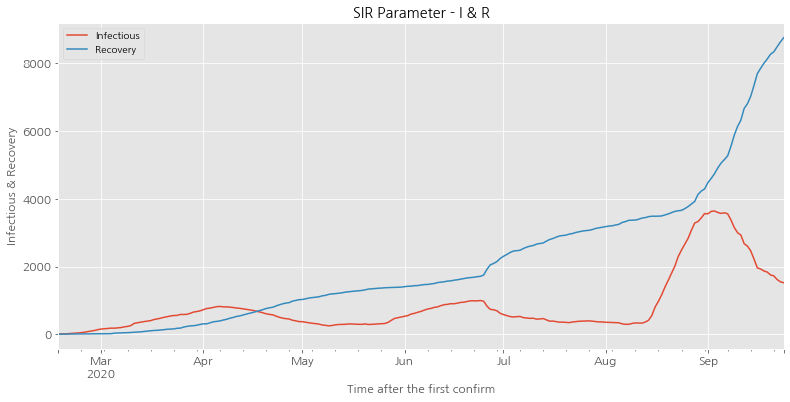

In [22]:
ir_plot = SIR_raw[['Infectious', 'Recovery']].plot(kind='line', title='SIR Parameter - I & R', figsize=(13, 6), legend=True, fontsize=12)
ir_plot.set_xlabel('Time after the first confirm', fontsize=12)        
ir_plot.set_ylabel('Infectious & Recovery', fontsize=12)    

Text(0, 0.5, 'γ')

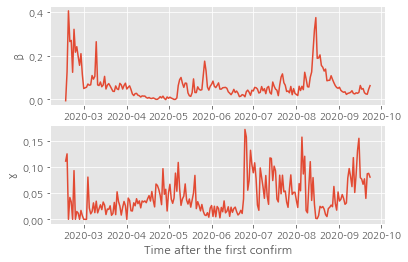

In [23]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(SIR_raw.index, SIR_raw['beta'])
axes[0].set_xlabel('Time after the first confirm', fontsize=12)         
axes[0].set_ylabel('β', fontsize=12)    

axes[1].plot(SIR_raw.index, SIR_raw['gamma'])
axes[1].set_xlabel('Time after the first confirm', fontsize=12)          
axes[1].set_ylabel('γ', fontsize=12)

## B) 베타값에 영향을 주는 데이터 전처리

### B-1) 검색어 "확진자" 검색 빈도

In [24]:
search = pd.read_excel("Search_확진자.xlsx")
search.index = search['날짜']
search.drop(['날짜'], axis = 1, inplace = True)
search['confirmation'] = search['확진자']
search.drop(['확진자'], axis = 1, inplace = True)
search

,confirmation
날짜,
2020-02-17,3.51425
2020-02-18,5.64353
2020-02-19,18.91238
2020-02-20,40.59205
2020-02-21,62.02665
...,...
2020-09-19,6.02097
2020-09-20,6.31939
2020-09-21,8.13411


In [25]:
to_predict = pd.date_range(start='20200924', end='20201005')
days = len(to_predict)

In [26]:
scaler = MinMaxScaler()
fitted = scaler.fit(search)
print(fitted.data_max_)

search_norm = scaler.transform(search)
search_norm = pd.DataFrame(search_norm, columns = search.columns, index = search.index)
search_norm = pd.DataFrame(search_norm)

[100.]


In [27]:
mins = fitted.data_min_
maxs = fitted.data_max_
print(mins, maxs)

[2.31268] [100.]


In [28]:
test_size = int(0.2*search_norm.shape[0])
feature_size = search_norm.shape[1]
window_size = 28
batch_size = 200

X_train, X_test, y_train, y_test = windowing(search_norm, window_size, test_size)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_naive = np.vstack([y_train[-1, :, :].reshape(1, feature_size), y_test[:-1, :, :].reshape(test_size-1, feature_size)])
y_naive = y_naive.reshape(test_size, feature_size)
y_naive = pd.DataFrame(y_naive, columns = search_norm.columns)

(148, 28, 1) (44, 28, 1) (148, 1, 1) (44, 1, 1)


In [29]:
y_test_df = y_test.reshape(test_size, feature_size)
y_test_df = pd.DataFrame(y_test_df, columns = search_norm.columns)

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = Sequential()
model.add(GRU(50, input_shape=[window_size, feature_size], return_sequences = True))
model.add(GRU(50))
model.add(Dense(feature_size))

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

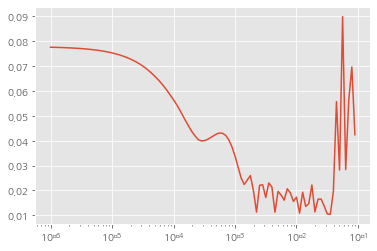

In [31]:
scheduling(model, X_train, y_train, 100, batch_size)

In [32]:
scheduled_train(model, X_train, y_train, epoch=400, batch_size = batch_size, lr=1e-02)

Train on 148 samples
Epoch 1/400
148/148 [==============================] - 6s 40ms/sample - loss: 0.0359 - mse: 0.0023
Epoch 2/400
148/148 [==============================] - 0s 478us/sample - loss: 0.0792 - mse: 0.0079
Epoch 3/400
148/148 [==============================] - 0s 465us/sample - loss: 0.0289 - mse: 0.0018
Epoch 4/400
148/148 [==============================] - 0s 391us/sample - loss: 0.0448 - mse: 0.0025
Epoch 5/400
148/148 [==============================] - 0s 377us/sample - loss: 0.0383 - mse: 0.0018
Epoch 6/400
148/148 [==============================] - 0s 337us/sample - loss: 0.0273 - mse: 0.0014
Epoch 7/400
148/148 [==============================] - 0s 350us/sample - loss: 0.0352 - mse: 0.0025
Epoch 8/400
148/148 [==============================] - 0s 337us/sample - loss: 0.0254 - mse: 0.0014
Epoch 9/400
148/148 [==============================] - 0s 364us/sample - loss: 0.0221 - mse: 6.5684e-04
Epoch 10/400
148/148 [==============================] - 0s 357us/sample - lo

Epoch 80/400
148/148 [==============================] - 0s 317us/sample - loss: 0.0089 - mse: 1.9708e-04
Epoch 81/400
148/148 [==============================] - 0s 310us/sample - loss: 0.0090 - mse: 1.9369e-04
Epoch 82/400
148/148 [==============================] - 0s 344us/sample - loss: 0.0089 - mse: 2.0143e-04
Epoch 83/400
148/148 [==============================] - 0s 323us/sample - loss: 0.0089 - mse: 1.9802e-04
Epoch 84/400
148/148 [==============================] - 0s 317us/sample - loss: 0.0091 - mse: 1.9594e-04
Epoch 85/400
148/148 [==============================] - 0s 405us/sample - loss: 0.0089 - mse: 1.9729e-04
Epoch 86/400
148/148 [==============================] - 0s 414us/sample - loss: 0.0089 - mse: 1.9879e-04
Epoch 87/400
148/148 [==============================] - 0s 354us/sample - loss: 0.0089 - mse: 1.9213e-04
Epoch 88/400
148/148 [==============================] - 0s 355us/sample - loss: 0.0089 - mse: 1.9452e-04
Epoch 89/400
148/148 [==============================] -

Epoch 158/400
148/148 [==============================] - 0s 411us/sample - loss: 0.0084 - mse: 1.7948e-04
Epoch 159/400
148/148 [==============================] - 0s 364us/sample - loss: 0.0084 - mse: 1.8593e-04
Epoch 160/400
148/148 [==============================] - 0s 330us/sample - loss: 0.0083 - mse: 1.7977e-04
Epoch 161/400
148/148 [==============================] - 0s 330us/sample - loss: 0.0084 - mse: 1.7815e-04
Epoch 162/400
148/148 [==============================] - 0s 323us/sample - loss: 0.0084 - mse: 1.8626e-04
Epoch 163/400
148/148 [==============================] - 0s 283us/sample - loss: 0.0089 - mse: 1.9992e-04
Epoch 164/400
148/148 [==============================] - 0s 344us/sample - loss: 0.0094 - mse: 1.8218e-04
Epoch 165/400
148/148 [==============================] - 0s 330us/sample - loss: 0.0088 - mse: 1.9423e-04
Epoch 166/400
148/148 [==============================] - 0s 296us/sample - loss: 0.0084 - mse: 1.8309e-04
Epoch 167/400
148/148 [=======================

Epoch 236/400
148/148 [==============================] - 0s 337us/sample - loss: 0.0084 - mse: 1.6744e-04
Epoch 237/400
148/148 [==============================] - 0s 324us/sample - loss: 0.0086 - mse: 1.7847e-04
Epoch 238/400
148/148 [==============================] - 0s 330us/sample - loss: 0.0082 - mse: 1.6587e-04
Epoch 239/400
148/148 [==============================] - 0s 344us/sample - loss: 0.0083 - mse: 1.5979e-04
Epoch 240/400
148/148 [==============================] - 0s 350us/sample - loss: 0.0084 - mse: 1.7806e-04
Epoch 241/400
148/148 [==============================] - 0s 398us/sample - loss: 0.0081 - mse: 1.6525e-04
Epoch 242/400
148/148 [==============================] - 0s 451us/sample - loss: 0.0083 - mse: 1.5807e-04
Epoch 243/400
148/148 [==============================] - 0s 323us/sample - loss: 0.0079 - mse: 1.5820e-04
Epoch 244/400
148/148 [==============================] - 0s 344us/sample - loss: 0.0086 - mse: 1.6878e-04
Epoch 245/400
148/148 [=======================

Epoch 314/400
148/148 [==============================] - 0s 323us/sample - loss: 0.0080 - mse: 1.5052e-04
Epoch 315/400
148/148 [==============================] - 0s 310us/sample - loss: 0.0082 - mse: 1.6989e-04
Epoch 316/400
148/148 [==============================] - 0s 290us/sample - loss: 0.0076 - mse: 1.4982e-04
Epoch 317/400
148/148 [==============================] - 0s 330us/sample - loss: 0.0076 - mse: 1.4361e-04
Epoch 318/400
148/148 [==============================] - 0s 312us/sample - loss: 0.0080 - mse: 1.6020e-04
Epoch 319/400
148/148 [==============================] - 0s 346us/sample - loss: 0.0080 - mse: 1.5708e-04
Epoch 320/400
148/148 [==============================] - 0s 337us/sample - loss: 0.0079 - mse: 1.5154e-04
Epoch 321/400
148/148 [==============================] - 0s 310us/sample - loss: 0.0076 - mse: 1.4891e-04
Epoch 322/400
148/148 [==============================] - 0s 317us/sample - loss: 0.0078 - mse: 1.5092e-04
Epoch 323/400
148/148 [=======================

Epoch 392/400
148/148 [==============================] - 0s 303us/sample - loss: 0.0083 - mse: 1.7387e-04
Epoch 393/400
148/148 [==============================] - 0s 344us/sample - loss: 0.0073 - mse: 1.4482e-04
Epoch 394/400
148/148 [==============================] - 0s 353us/sample - loss: 0.0070 - mse: 1.3634e-04
Epoch 395/400
148/148 [==============================] - 0s 297us/sample - loss: 0.0075 - mse: 1.5280e-04
Epoch 396/400
148/148 [==============================] - 0s 398us/sample - loss: 0.0069 - mse: 1.3426e-04
Epoch 397/400
148/148 [==============================] - 0s 399us/sample - loss: 0.0070 - mse: 1.3827e-04
Epoch 398/400
148/148 [==============================] - 0s 337us/sample - loss: 0.0067 - mse: 1.3205e-04
Epoch 399/400
148/148 [==============================] - 0s 324us/sample - loss: 0.0071 - mse: 1.3479e-04
Epoch 400/400
148/148 [==============================] - 0s 342us/sample - loss: 0.0072 - mse: 1.3440e-04


In [33]:
y_hat = model.predict(X_test)
y_hat = y_hat.reshape(test_size, feature_size)
y_hat = pd.DataFrame(y_hat, columns = search_norm.columns)
error_mat(y_test_df=y_test_df, y_naive=y_naive, y_hat=y_hat)

           confirmation
naive          0.001119
predicted      0.002234


C:\Users\hnn02\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


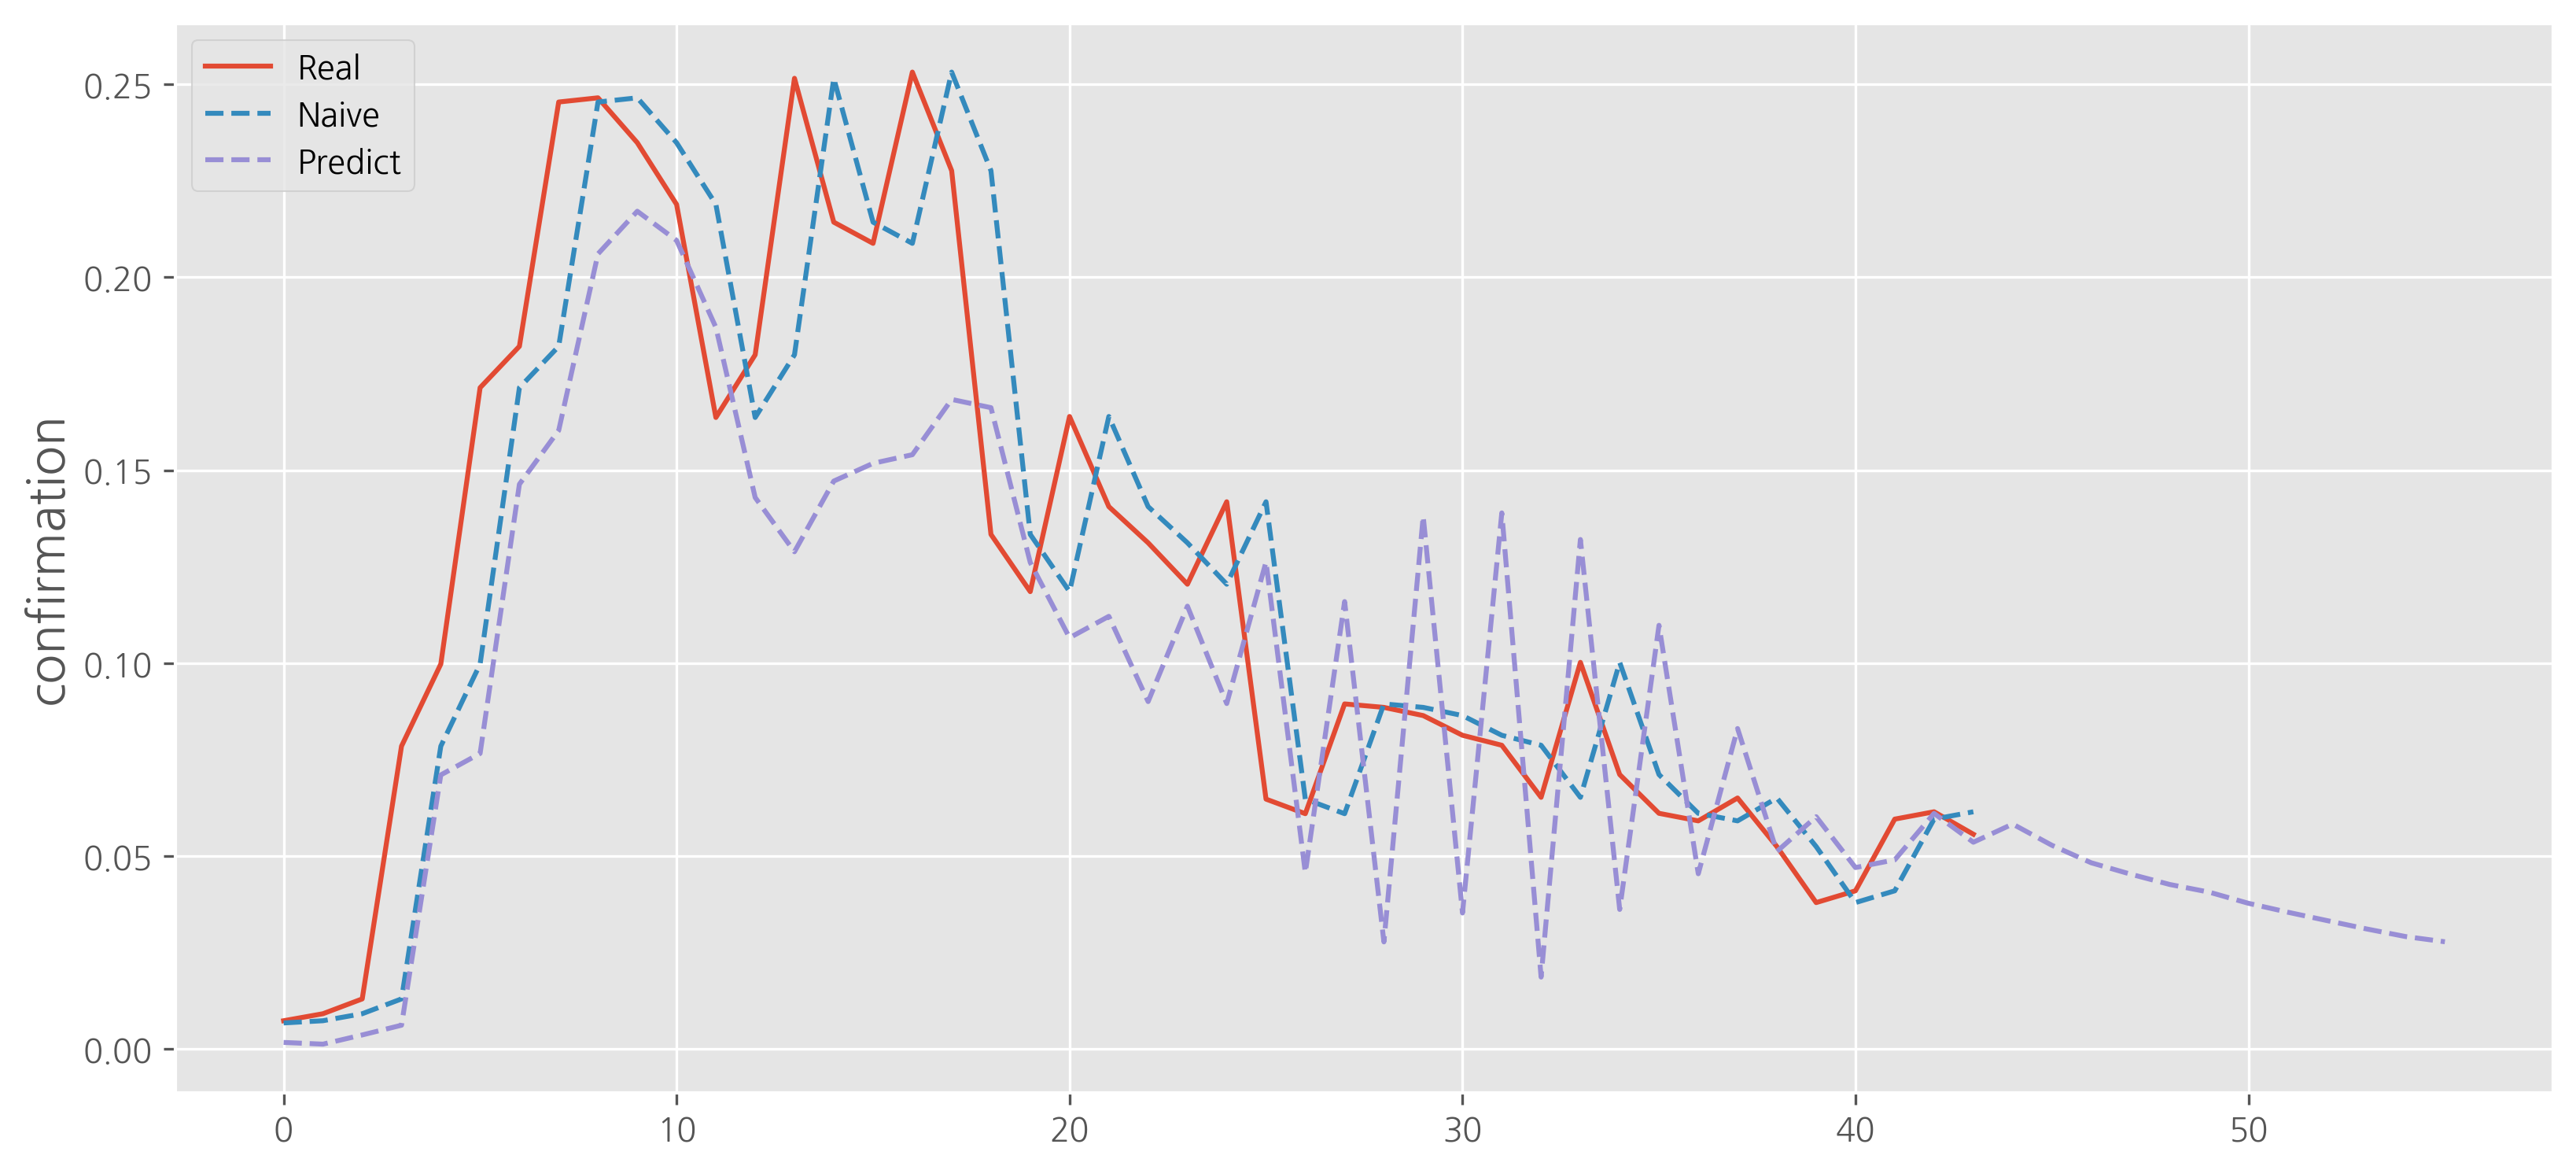

In [34]:
y_hat_pred = future_pred(data=search_norm, window_size=window_size, 
                    feature_size=feature_size, days_to_predict=days, y_hat=y_hat, model=model)

predplot(y_test_df, y_naive, y_hat_pred, feature_size)

In [35]:
y_hat_pred = y_hat_pred.iloc[-days:,:]
y_hat_pred.index = to_predict


search_updated = pd.concat([search_norm, y_hat_pred])

data_search = search_updated
data_search.index = pd.date_range(start='20200217', end='20201005')
data_search

,confirmation
2020-02-17,0.012300
2020-02-18,0.034097
2020-02-19,0.169927
2020-02-20,0.391856
2020-02-21,0.611277
...,...
2020-10-01,0.035472
2020-10-02,0.033300
2020-10-03,0.031148
2020-10-04,0.029160


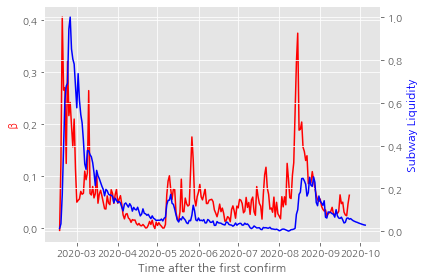

In [36]:
embedded_plots(SIR_raw.index, SIR_raw['beta'], data_search.index, data_search['confirmation'], 
               'Time after the first confirm', 'β', 'Subway Liquidity')

### B-2) 지하철 이용객 수

In [37]:
days = (date(2020, 10, 5) - date(2020, 8, 31)).days
days

35

In [38]:
subway = pd.DataFrame()
for months in range(1, 9):
    month_sub = liquidpop_month(months)
    subway = pd.concat([subway, month_sub])
subway = pd.DataFrame(subway['승차총승객수'])
subway['subway'] = subway['승차총승객수']
subway.drop(['승차총승객수'], axis = 1, inplace = True)

subway.index = pd.to_datetime(subway.index.astype(str), format='%Y%m%d')
subway

,subway
사용일자,
2020-01-01,3479698.0
2020-01-02,7691529.0
2020-01-03,8224917.0
2020-01-04,6042529.0
2020-01-05,4425521.0
...,...
2020-08-27,4913077.0
2020-08-28,5325698.0
2020-08-29,2798529.0


In [39]:
to_predict = pd.date_range(start='20200901', end='20201005')
days = len(to_predict)

In [40]:
scaler = MinMaxScaler()
fitted = scaler.fit(subway)
print(fitted.data_max_)

subway_norm = scaler.transform(subway)
subway_norm = pd.DataFrame(subway_norm, columns = subway.columns, index = subway.index)
subway_norm = pd.DataFrame(subway_norm)

[8492225.]


In [41]:
mins = fitted.data_min_
maxs = fitted.data_max_
print(mins, maxs)

[1876648.] [8492225.]


In [42]:
test_size = int(0.2*subway_norm.shape[0])
feature_size = subway_norm.shape[1]
window_size = 28
batch_size = 200

X_train, X_test, y_train, y_test = windowing(subway_norm, window_size, test_size)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_naive = np.vstack([y_train[-1, :, :].reshape(1, feature_size), y_test[:-1, :, :].reshape(test_size-1, feature_size)])
y_naive = y_naive.reshape(test_size, feature_size)
y_naive = pd.DataFrame(y_naive, columns = subway_norm.columns)

y_test_df = y_test.reshape(test_size, feature_size)
y_test_df = pd.DataFrame(y_test_df, columns = subway_norm.columns)

(168, 28, 1) (48, 28, 1) (168, 1, 1) (48, 1, 1)


In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = Sequential()
model.add(GRU(50, input_shape=[window_size, feature_size], return_sequences = True))
model.add(GRU(50))
model.add(Dense(1))

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

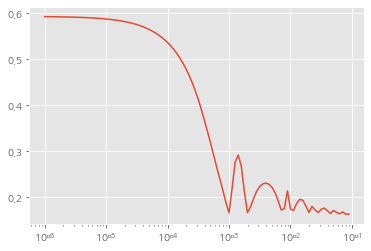

In [44]:
scheduling(model, X_train, y_train, 100, batch_size)

In [45]:
scheduled_train(model, X_train, y_train, epoch=400, batch_size = batch_size, lr=1e-02)

Train on 168 samples
Epoch 1/400
168/168 [==============================] - 6s 34ms/sample - loss: 0.1621 - mse: 0.0460
Epoch 2/400
168/168 [==============================] - 0s 451us/sample - loss: 0.2601 - mse: 0.0896
Epoch 3/400
168/168 [==============================] - 0s 439us/sample - loss: 0.1933 - mse: 0.0449
Epoch 4/400
168/168 [==============================] - 0s 392us/sample - loss: 0.1652 - mse: 0.0478
Epoch 5/400
168/168 [==============================] - 0s 411us/sample - loss: 0.1768 - mse: 0.0550
Epoch 6/400
168/168 [==============================] - 0s 362us/sample - loss: 0.1595 - mse: 0.0368
Epoch 7/400
168/168 [==============================] - 0s 386us/sample - loss: 0.1698 - mse: 0.0370
Epoch 8/400
168/168 [==============================] - 0s 386us/sample - loss: 0.1668 - mse: 0.0360
Epoch 9/400
168/168 [==============================] - 0s 392us/sample - loss: 0.1573 - mse: 0.0348
Epoch 10/400
168/168 [==============================] - 0s 374us/sample - loss: 

168/168 [==============================] - 0s 338us/sample - loss: 0.0673 - mse: 0.0097
Epoch 83/400
168/168 [==============================] - 0s 338us/sample - loss: 0.0731 - mse: 0.0111
Epoch 84/400
168/168 [==============================] - 0s 362us/sample - loss: 0.0664 - mse: 0.0086
Epoch 85/400
168/168 [==============================] - 0s 380us/sample - loss: 0.0557 - mse: 0.0074
Epoch 86/400
168/168 [==============================] - 0s 344us/sample - loss: 0.0684 - mse: 0.0094
Epoch 87/400
168/168 [==============================] - 0s 392us/sample - loss: 0.0638 - mse: 0.0086
Epoch 88/400
168/168 [==============================] - 0s 380us/sample - loss: 0.0535 - mse: 0.0070
Epoch 89/400
168/168 [==============================] - 0s 380us/sample - loss: 0.0638 - mse: 0.0079
Epoch 90/400
168/168 [==============================] - 0s 374us/sample - loss: 0.0594 - mse: 0.0079
Epoch 91/400
168/168 [==============================] - 0s 386us/sample - loss: 0.0590 - mse: 0.0082
Epo

Epoch 163/400
168/168 [==============================] - 0s 350us/sample - loss: 0.0350 - mse: 0.0048
Epoch 164/400
168/168 [==============================] - 0s 350us/sample - loss: 0.0446 - mse: 0.0055
Epoch 165/400
168/168 [==============================] - 0s 350us/sample - loss: 0.0394 - mse: 0.0053
Epoch 166/400
168/168 [==============================] - 0s 374us/sample - loss: 0.0445 - mse: 0.0055
Epoch 167/400
168/168 [==============================] - 0s 332us/sample - loss: 0.0393 - mse: 0.0048
Epoch 168/400
168/168 [==============================] - 0s 374us/sample - loss: 0.0476 - mse: 0.0061
Epoch 169/400
168/168 [==============================] - 0s 344us/sample - loss: 0.0351 - mse: 0.0048
Epoch 170/400
168/168 [==============================] - 0s 356us/sample - loss: 0.0429 - mse: 0.0050
Epoch 171/400
168/168 [==============================] - 0s 338us/sample - loss: 0.0388 - mse: 0.0051
Epoch 172/400
168/168 [==============================] - 0s 376us/sample - loss: 0

Epoch 244/400
168/168 [==============================] - 0s 339us/sample - loss: 0.0266 - mse: 0.0040
Epoch 245/400
168/168 [==============================] - 0s 338us/sample - loss: 0.0358 - mse: 0.0047
Epoch 246/400
168/168 [==============================] - 0s 404us/sample - loss: 0.0302 - mse: 0.0039
Epoch 247/400
168/168 [==============================] - 0s 445us/sample - loss: 0.0293 - mse: 0.0041
Epoch 248/400
168/168 [==============================] - 0s 380us/sample - loss: 0.0318 - mse: 0.0044
Epoch 249/400
168/168 [==============================] - 0s 368us/sample - loss: 0.0301 - mse: 0.0040
Epoch 250/400
168/168 [==============================] - 0s 386us/sample - loss: 0.0299 - mse: 0.0039
Epoch 251/400
168/168 [==============================] - 0s 367us/sample - loss: 0.0295 - mse: 0.0041
Epoch 252/400
168/168 [==============================] - 0s 380us/sample - loss: 0.0279 - mse: 0.0040
Epoch 253/400
168/168 [==============================] - 0s 368us/sample - loss: 0

Epoch 325/400
168/168 [==============================] - 0s 327us/sample - loss: 0.0248 - mse: 0.0036
Epoch 326/400
168/168 [==============================] - 0s 338us/sample - loss: 0.0218 - mse: 0.0034
Epoch 327/400
168/168 [==============================] - 0s 340us/sample - loss: 0.0269 - mse: 0.0037
Epoch 328/400
168/168 [==============================] - 0s 362us/sample - loss: 0.0288 - mse: 0.0035
Epoch 329/400
168/168 [==============================] - 0s 350us/sample - loss: 0.0218 - mse: 0.0035
Epoch 330/400
168/168 [==============================] - 0s 358us/sample - loss: 0.0249 - mse: 0.0037
Epoch 331/400
168/168 [==============================] - 0s 416us/sample - loss: 0.0233 - mse: 0.0035
Epoch 332/400
168/168 [==============================] - 0s 416us/sample - loss: 0.0235 - mse: 0.0034
Epoch 333/400
168/168 [==============================] - 0s 380us/sample - loss: 0.0231 - mse: 0.0036
Epoch 334/400
168/168 [==============================] - 0s 445us/sample - loss: 0

In [46]:
y_hat = model.predict(X_test)
y_hat = y_hat.reshape(test_size, feature_size)
y_hat = pd.DataFrame(y_hat, columns = subway_norm.columns)
error_mat(y_test_df=y_test_df, y_naive=y_naive, y_hat=y_hat)

             subway
naive      0.062751
predicted  0.006036


C:\Users\hnn02\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


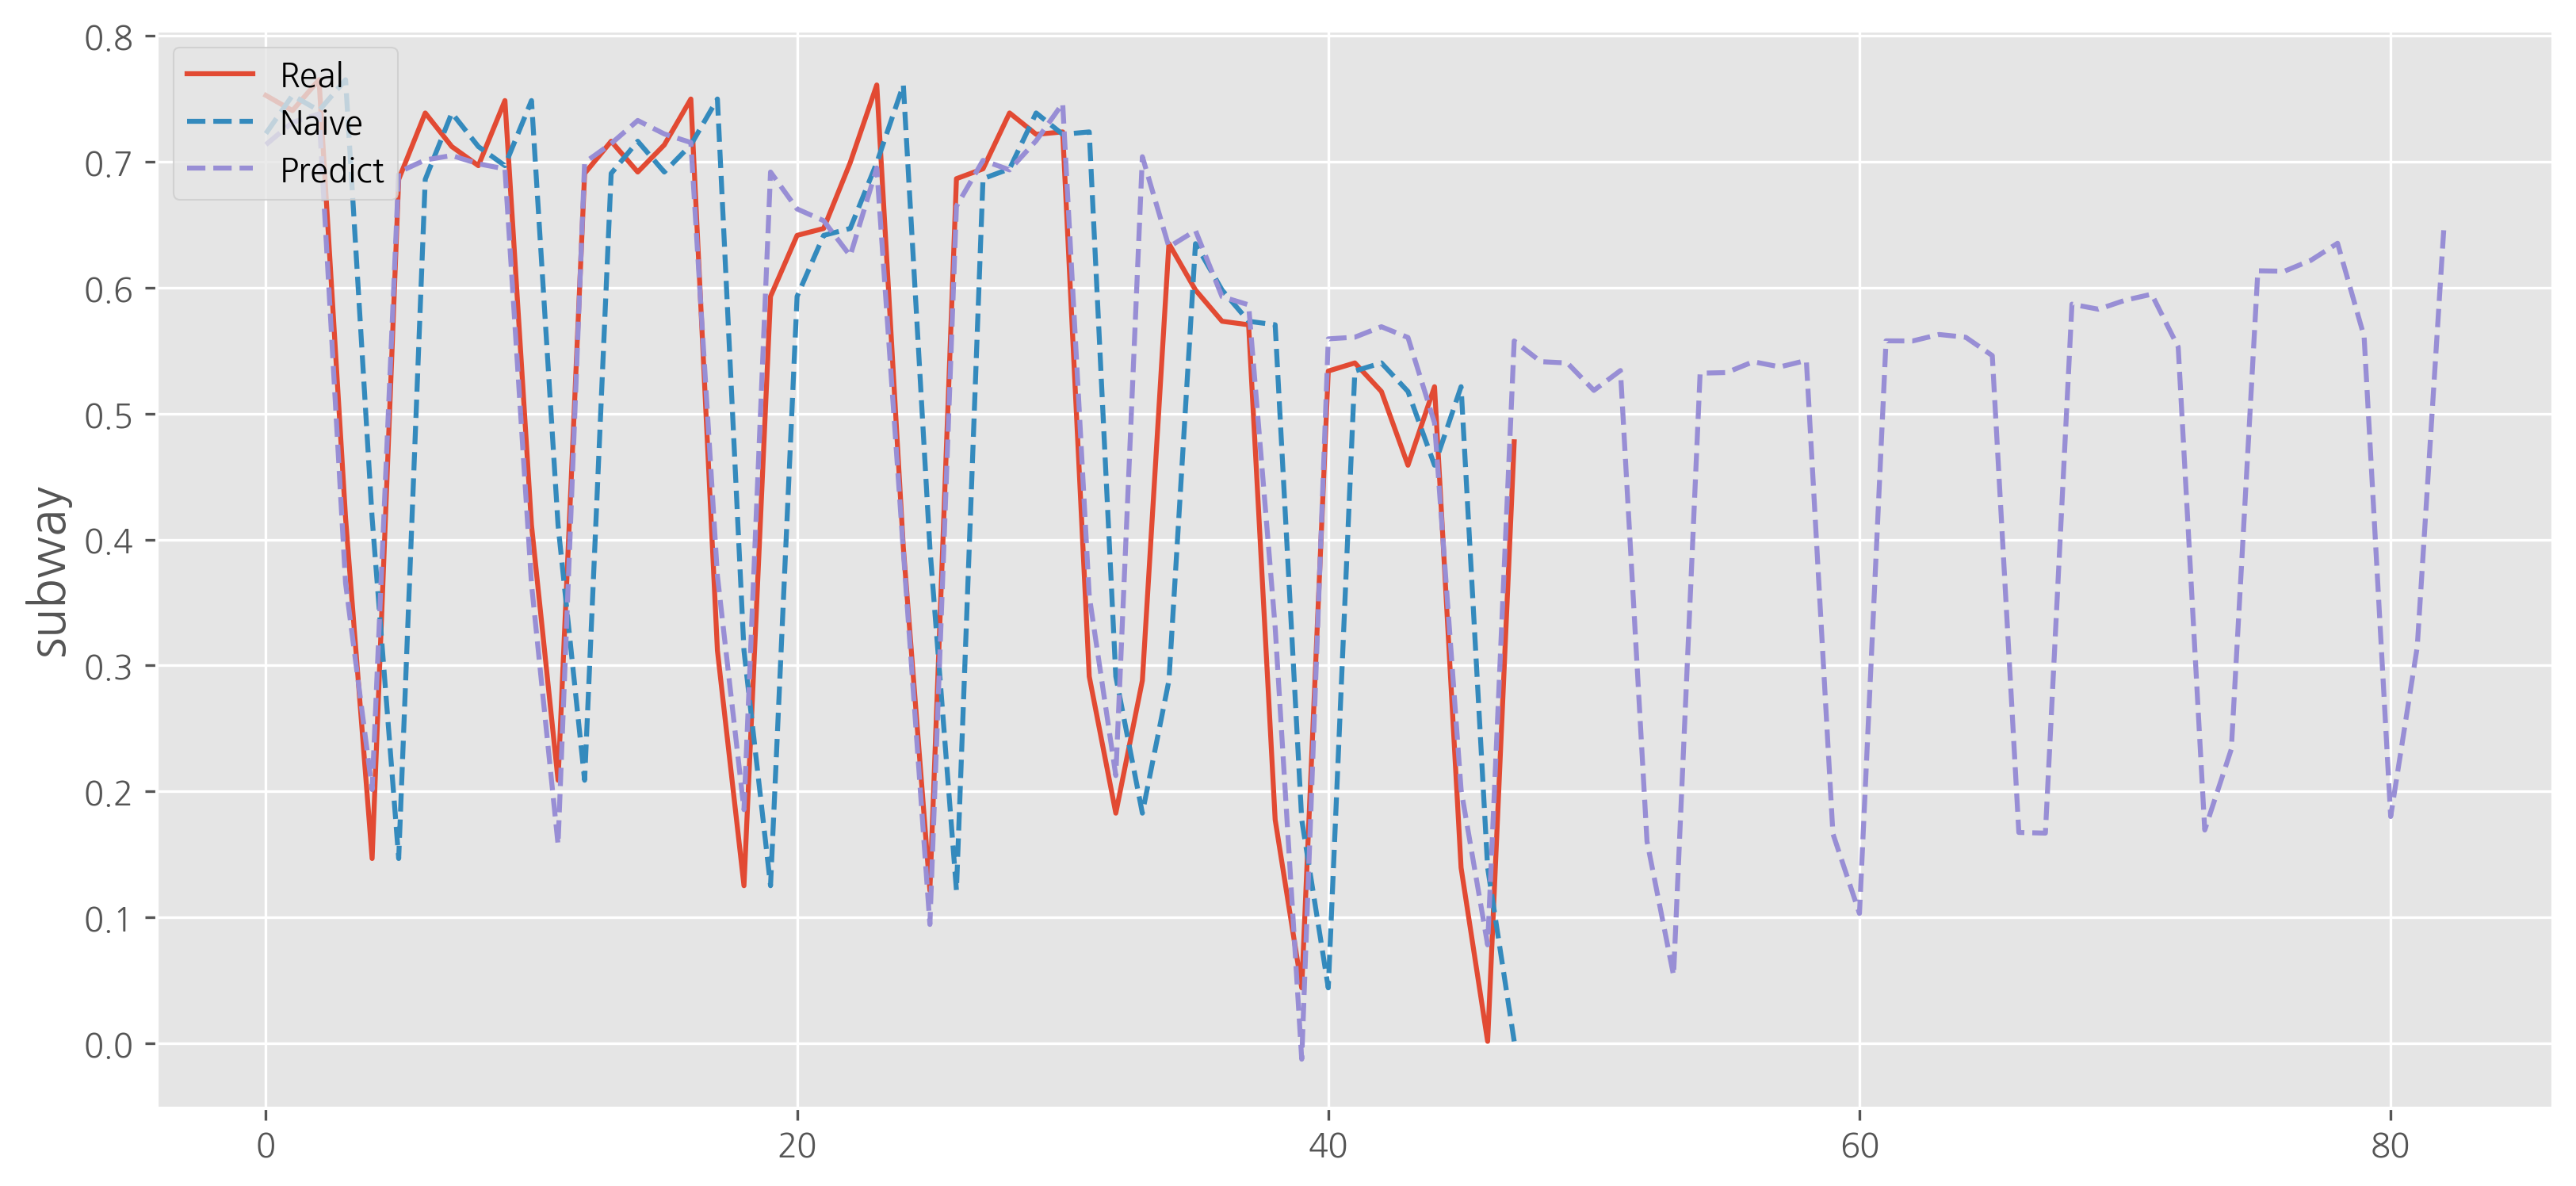

In [47]:
y_hat_pred = future_pred(data=subway_norm, window_size=window_size, 
                    feature_size=feature_size, days_to_predict=days, y_hat=y_hat, model=model)

predplot(y_test_df, y_naive, y_hat_pred, feature_size)

In [48]:
y_hat_pred = y_hat_pred.iloc[-days:,:]
y_hat_pred.index = to_predict

subway_updated = pd.concat([subway_norm, y_hat_pred])

subway_updated['subway'] = subway_updated['subway']*(maxs[0]-mins[0]) + mins[0]

subway_updated['subway_MA7'] = subway_updated.rolling(7).mean()

data_subway = subway_updated.loc[date(2020,2,17):]

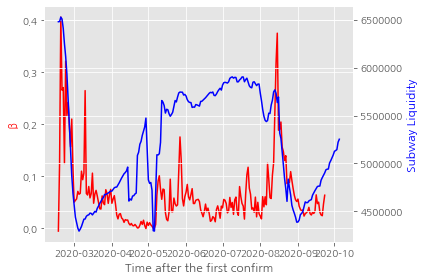

In [49]:
embedded_plots(SIR_raw.index, SIR_raw['beta'], data_subway.index, data_subway['subway_MA7'], 
               'Time after the first confirm', 'β', 'Subway Liquidity')

### B-3) 고속도로 교통량

In [50]:
traffic = pd.read_csv('traffic_v2.csv')

traffic['Traffic_MA7'] = traffic['traffic'].rolling(7).mean()
traffic['Traffic_MA14'] = traffic['traffic'].rolling(14).mean()

In [51]:
traffic.index = traffic['Unnamed: 0']
traffic.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [52]:
to_predict = pd.date_range(start='20200924', end='20201005')
days = len(to_predict)

In [53]:
holidays = pd.date_range(start = '20200930', end = '20201005')
len_holidays = len(holidays)
traffic_seol = traffic[(traffic.index <= 20200128)]
traffic_seol = traffic_seol.iloc[-len_holidays:, :]
traffic_seol.index = holidays

In [54]:
traffic.index = pd.to_datetime(traffic.index.astype(str), format='%Y%m%d')

In [55]:
traffic = pd.DataFrame(traffic['traffic'])

In [56]:
scaler = MinMaxScaler()
fitted = scaler.fit(traffic)

traffic_norm = scaler.transform(traffic)
traffic_norm = pd.DataFrame(traffic_norm, columns = traffic.columns, index = traffic.index)
traffic_norm = pd.DataFrame(traffic_norm)

mins = fitted.data_min_
maxs = fitted.data_max_
print(mins, maxs)

[1908972.] [5076768.]


In [57]:
test_size = int(0.2*traffic_norm.shape[0])
feature_size = traffic_norm.shape[1]
window_size = 28
batch_size = 200

X_train, X_test, y_train, y_test = windowing(traffic_norm, window_size, test_size)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_naive = np.vstack([y_train[-1, :, :].reshape(1, feature_size), y_test[:-1, :, :].reshape(test_size-1, feature_size)])
y_naive = y_naive.reshape(test_size, feature_size)
y_naive = pd.DataFrame(y_naive, columns = traffic_norm.columns)

y_test_df = y_test.reshape(test_size, feature_size)
y_test_df = pd.DataFrame(y_test_df, columns = traffic_norm.columns)
# y_test_df

(308, 28, 1) (84, 28, 1) (308, 1, 1) (84, 1, 1)


In [58]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = Sequential()
model.add(GRU(100, input_shape=[window_size, feature_size], return_sequences = True))
model.add(GRU(100))
model.add(Dropout(0.2))
model.add(Dense(feature_size, activation="relu"))

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

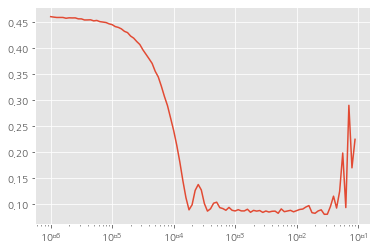

In [59]:
scheduling(model, X_train, y_train, 100, batch_size)

In [60]:
scheduled_train(model, X_train, y_train, epoch=400, batch_size = batch_size, lr=1e-03)

Train on 308 samples
Epoch 1/400
308/308 [==============================] - 6s 19ms/sample - loss: 0.0958 - mse: 0.0167
Epoch 2/400
308/308 [==============================] - 0s 800us/sample - loss: 0.0931 - mse: 0.0169
Epoch 3/400
308/308 [==============================] - 0s 706us/sample - loss: 0.0880 - mse: 0.0152
Epoch 4/400
308/308 [==============================] - 0s 716us/sample - loss: 0.0851 - mse: 0.0145
Epoch 5/400
308/308 [==============================] - 0s 845us/sample - loss: 0.0866 - mse: 0.0152
Epoch 6/400
308/308 [==============================] - 0s 749us/sample - loss: 0.0814 - mse: 0.0143
Epoch 7/400
308/308 [==============================] - 0s 712us/sample - loss: 0.0794 - mse: 0.0134
Epoch 8/400
308/308 [==============================] - 0s 725us/sample - loss: 0.0806 - mse: 0.0133
Epoch 9/400
308/308 [==============================] - 0s 780us/sample - loss: 0.0774 - mse: 0.0127
Epoch 10/400
308/308 [==============================] - 0s 784us/sample - loss: 

308/308 [==============================] - 0s 793us/sample - loss: 0.0640 - mse: 0.0095
Epoch 83/400
308/308 [==============================] - 0s 855us/sample - loss: 0.0620 - mse: 0.0093
Epoch 84/400
308/308 [==============================] - 0s 933us/sample - loss: 0.0613 - mse: 0.0091
Epoch 85/400
308/308 [==============================] - 0s 848us/sample - loss: 0.0588 - mse: 0.0085
Epoch 86/400
308/308 [==============================] - 0s 767us/sample - loss: 0.0584 - mse: 0.0080
Epoch 87/400
308/308 [==============================] - 0s 829us/sample - loss: 0.0596 - mse: 0.0083
Epoch 88/400
308/308 [==============================] - 0s 997us/sample - loss: 0.0584 - mse: 0.0084
Epoch 89/400
308/308 [==============================] - 0s 819us/sample - loss: 0.0601 - mse: 0.0088
Epoch 90/400
308/308 [==============================] - 0s 774us/sample - loss: 0.0588 - mse: 0.0083
Epoch 91/400
308/308 [==============================] - 0s 913us/sample - loss: 0.0581 - mse: 0.0084
Epo

308/308 [==============================] - 0s 907us/sample - loss: 0.0533 - mse: 0.0076
Epoch 163/400
308/308 [==============================] - 0s 839us/sample - loss: 0.0575 - mse: 0.0083
Epoch 164/400
308/308 [==============================] - 0s 751us/sample - loss: 0.0538 - mse: 0.0073
Epoch 165/400
308/308 [==============================] - 0s 754us/sample - loss: 0.0534 - mse: 0.0076
Epoch 166/400
308/308 [==============================] - 0s 952us/sample - loss: 0.0546 - mse: 0.0080
Epoch 167/400
308/308 [==============================] - 0s 890us/sample - loss: 0.0514 - mse: 0.0072
Epoch 168/400
308/308 [==============================] - 0s 767us/sample - loss: 0.0508 - mse: 0.0070
Epoch 169/400
308/308 [==============================] - 0s 748us/sample - loss: 0.0539 - mse: 0.0075
Epoch 170/400
308/308 [==============================] - 0s 971us/sample - loss: 0.0550 - mse: 0.0074
Epoch 171/400
308/308 [==============================] - 0s 874us/sample - loss: 0.0539 - mse: 0

308/308 [==============================] - 0s 810us/sample - loss: 0.0503 - mse: 0.0068
Epoch 243/400
308/308 [==============================] - 0s 839us/sample - loss: 0.0514 - mse: 0.0072
Epoch 244/400
308/308 [==============================] - 0s 842us/sample - loss: 0.0505 - mse: 0.0072
Epoch 245/400
308/308 [==============================] - 0s 969us/sample - loss: 0.0507 - mse: 0.0072
Epoch 246/400
308/308 [==============================] - 0s 790us/sample - loss: 0.0503 - mse: 0.0071
Epoch 247/400
308/308 [==============================] - 0s 916us/sample - loss: 0.0477 - mse: 0.0066
Epoch 248/400
308/308 [==============================] - 0s 917us/sample - loss: 0.0490 - mse: 0.0068
Epoch 249/400
308/308 [==============================] - 0s 1ms/sample - loss: 0.0508 - mse: 0.0073
Epoch 250/400
308/308 [==============================] - 0s 803us/sample - loss: 0.0493 - mse: 0.0069
Epoch 251/400
308/308 [==============================] - 0s 826us/sample - loss: 0.0482 - mse: 0.0

308/308 [==============================] - 0s 751us/sample - loss: 0.0464 - mse: 0.0065
Epoch 323/400
308/308 [==============================] - 0s 855us/sample - loss: 0.0455 - mse: 0.0064
Epoch 324/400
308/308 [==============================] - 0s 871us/sample - loss: 0.0466 - mse: 0.0065
Epoch 325/400
308/308 [==============================] - 0s 798us/sample - loss: 0.0443 - mse: 0.0061
Epoch 326/400
308/308 [==============================] - 0s 790us/sample - loss: 0.0475 - mse: 0.0066
Epoch 327/400
308/308 [==============================] - 0s 894us/sample - loss: 0.0441 - mse: 0.0062
Epoch 328/400
308/308 [==============================] - 0s 887us/sample - loss: 0.0451 - mse: 0.0061
Epoch 329/400
308/308 [==============================] - 0s 771us/sample - loss: 0.0468 - mse: 0.0068
Epoch 330/400
308/308 [==============================] - 0s 787us/sample - loss: 0.0457 - mse: 0.0064
Epoch 331/400
308/308 [==============================] - 0s 955us/sample - loss: 0.0467 - mse: 0

In [61]:
y_hat = model.predict(X_test)
y_hat = y_hat.reshape(test_size, feature_size)
y_hat = pd.DataFrame(y_hat, columns = traffic_norm.columns)
error_mat(y_test_df=y_test_df, y_naive=y_naive, y_hat=y_hat)

            traffic
naive      0.014207
predicted  0.006364


C:\Users\hnn02\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


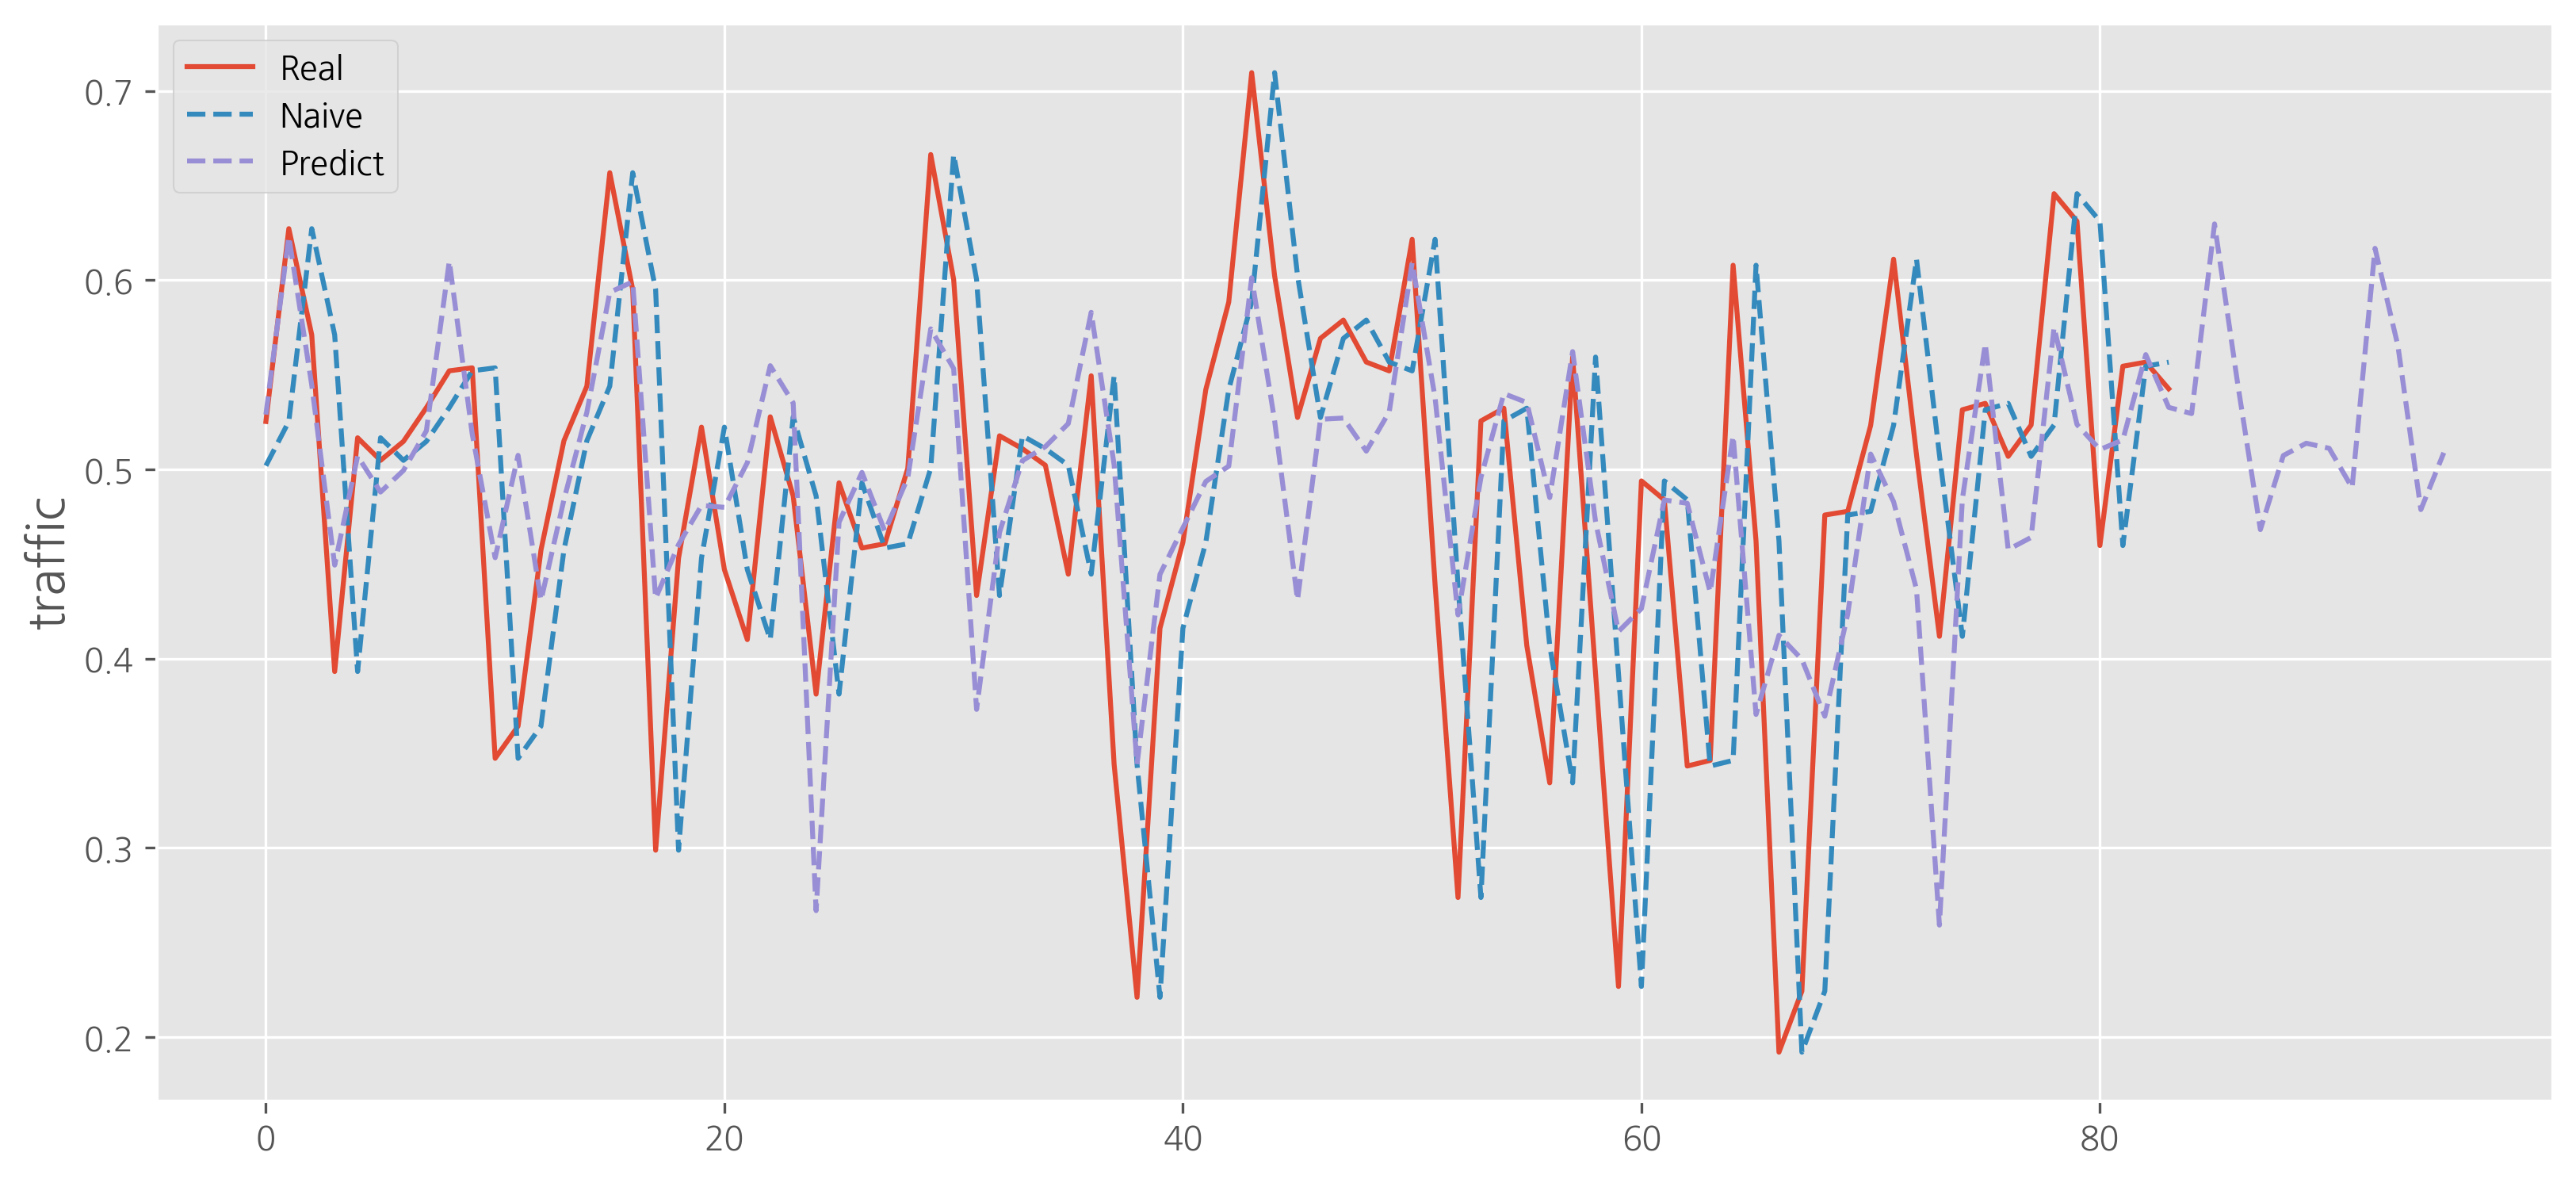

In [62]:
y_hat_pred = future_pred(data=traffic_norm, window_size=window_size, 
                    feature_size=feature_size, days_to_predict=days, y_hat=y_hat, model=model)

predplot(y_test_df, y_naive, y_hat_pred, feature_size)

In [63]:
y_hat_pred = y_hat_pred.iloc[-days:,:]
y_hat_pred.index = to_predict

traffic_updated = pd.concat([traffic_norm, y_hat_pred])
traffic_updated['traffic'] = traffic_updated['traffic']*(maxs[0]-mins[0]) + mins[0]
traffic_updated['traffic_MA7'] = traffic_updated['traffic'].rolling(7).mean()

data_traffic_predicted = traffic_updated.loc[date(2020,2,17):]

In [64]:
traffic_updated_constraint = traffic_updated.loc[date(2020,2,1):date(2020,9,29)]
traffic_updated_constraint = pd.DataFrame(pd.concat([traffic_updated_constraint['traffic'], traffic_seol['traffic']], axis = 0))
traffic_updated_constraint['traffic_MA7'] = traffic_updated_constraint['traffic'].rolling(7).mean()
data_traffic_constraint = traffic_updated_constraint.loc[date(2020,2,17):]
data_traffic_constraint

,traffic,traffic_MA7
2020-02-17,3011249.0,3.152278e+06
2020-02-18,3183342.0,3.133881e+06
2020-02-19,3304551.0,3.175489e+06
2020-02-20,3337665.0,3.178370e+06
2020-02-21,3476660.0,3.152833e+06
...,...,...
2020-10-01,3643052.0,3.610760e+06
2020-10-02,4650941.0,3.717499e+06
2020-10-03,3712092.0,3.727976e+06
2020-10-04,2596229.0,3.614271e+06


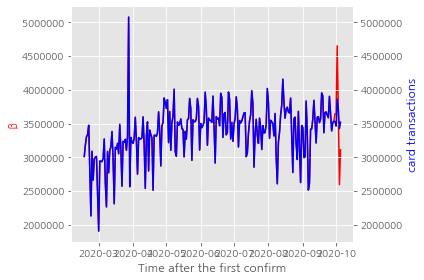

In [65]:
embedded_plots(data_traffic_constraint.index, data_traffic_constraint['traffic'], data_traffic_predicted.index, data_traffic_predicted['traffic'], 
               'Time after the first confirm', 'β', 'card transactions')

In [66]:
Data_constraint = pd.concat([SIR_raw, data_search, data_subway, data_traffic_constraint], axis =1)

# 2-2) Training

## A) 베타 예측 모델

In [67]:
Data=Data_constraint
Data.index = pd.date_range(start='20200217', end='20201005')
Data

,Susceptibility,Infectious,Recovery,gamma,beta,confirmation,subway,subway_MA7,traffic,traffic_MA7
2020-02-17,26022426.0,18.0,8.0,0.111111,-0.006672,0.012300,7.197144e+06,6.479220e+06,3011249.0,3.152278e+06
2020-02-18,26022426.0,16.0,10.0,0.125000,0.125000,0.034097,7.205498e+06,6.481062e+06,3183342.0,3.133881e+06
2020-02-19,26022424.0,16.0,12.0,0.000000,0.405466,0.169927,7.306690e+06,6.527578e+06,3304551.0,3.175489e+06
2020-02-20,26022416.0,24.0,12.0,0.041667,0.264811,0.391856,7.168504e+06,6.507125e+06,3337665.0,3.178370e+06
2020-02-21,26022409.0,30.0,13.0,0.033333,0.269723,0.611277,7.038538e+06,6.409674e+06,3476660.0,3.152833e+06
...,...,...,...,...,...,...,...,...,...,...
2020-10-01,NaN,NaN,NaN,NaN,NaN,0.035472,6.079133e+06,5.126847e+06,3643052.0,3.610760e+06
2020-10-02,NaN,NaN,NaN,NaN,NaN,0.033300,5.588914e+06,5.134675e+06,4650941.0,3.717499e+06
2020-10-03,NaN,NaN,NaN,NaN,NaN,0.031148,3.067772e+06,5.144815e+06,3712092.0,3.727976e+06
2020-10-04,NaN,NaN,NaN,NaN,NaN,0.029160,3.958133e+06,5.221507e+06,2596229.0,3.614271e+06


In [68]:
scaler = MinMaxScaler()
fitted = scaler.fit(Data)
minmax = pd.DataFrame(index = ['min', 'max'], columns = Data.columns, data = 0)
minmax.loc['min'] = fitted.data_min_
minmax.loc['max'] = fitted.data_max_
print(minmax)

Data_norm = scaler.transform(Data)
Data_norm = pd.DataFrame(Data_norm, columns = Data.columns, index = Data.index)

     Susceptibility  Infectious  Recovery     gamma      beta  confirmation  \
min      26012187.0        16.0       8.0  0.000000 -0.006672           0.0   
max      26022426.0      3636.0    8742.0  0.171604  0.405466           1.0   

        subway    subway_MA7    traffic   traffic_MA7  
min  1876648.0  4.293929e+06  1908972.0  2.713178e+06  
max  7306690.0  6.527578e+06  5076768.0  3.779200e+06  


In [69]:
minbeta = minmax.loc['min', 'beta']
maxbeta = minmax.loc['max', 'beta']
features = ['beta', 'confirmation', 'subway_MA7', 'traffic_MA7']
Data_norm = Data_norm[features]
Data_norm

,beta,confirmation,subway_MA7,traffic_MA7
2020-02-17,0.000000,0.012300,0.978350,0.411905
2020-02-18,0.319486,0.034097,0.979175,0.394647
2020-02-19,1.000000,0.169927,1.000000,0.433678
2020-02-20,0.658718,0.391856,0.990843,0.436381
2020-02-21,0.670637,0.611277,0.947214,0.412425
...,...,...,...,...
2020-10-01,NaN,0.035472,0.372896,0.841992
2020-10-02,NaN,0.033300,0.376400,0.942120
2020-10-03,NaN,0.031148,0.380940,0.951948
2020-10-04,NaN,0.029160,0.415275,0.845286


In [70]:
test_size = int(0.15*len(pd.date_range(start='20200217', end='20200923')))
feature_size = Data_norm.shape[1]
window_size = 14
batch_size = 32

In [71]:
Data.index[-int(0.15*Data_norm.shape[0]):]

DatetimeIndex(['2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13',
               '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17',
               '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21',
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03',
               '2020-10-04', '2020-10-05'],
              dtype='datetime64[ns]', freq='D')

In [72]:
X_train, X_test, y_train, y_test = windowing_v3(data = Data_norm, start_date = date(2020,2,17), end_date = date(2020,9,23), 
                                                target = 'beta', window_size = window_size, test_size = test_size)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(173, 14, 4) (33, 14, 4) (173, 1, 4) (33, 1, 4)


In [73]:
start_date = date(2020,2,17)
end_date = date(2020,9,23)
data_scope = Data_norm.loc[start_date:end_date]

In [74]:
y_naive = np.vstack([y_train[-1, :, :].reshape(1, feature_size), y_test[:-1, :, :].reshape(test_size-1, feature_size)])
y_naive = y_naive.reshape(test_size, feature_size)
y_naive = pd.DataFrame(y_naive, columns = Data_norm.columns)
y_naive.index = data_scope.index[-test_size:]
y_naive

,beta,confirmation,subway_MA7,traffic_MA7
2020-08-22,0.330014,0.218886,0.245842,0.947166
2020-08-23,0.352269,0.163670,0.197711,0.877877
2020-08-24,0.221830,0.179914,0.139014,0.770225
2020-08-25,0.226511,0.251567,0.243008,0.751712
2020-08-26,0.227647,0.214282,0.202948,0.731945
2020-08-27,0.278021,0.208789,0.168860,0.668363
2020-08-28,0.236755,0.253175,0.120485,0.575973
2020-08-29,0.200118,0.227618,0.099694,0.549567
2020-08-30,0.167494,0.133370,0.083548,0.529616
2020-08-31,0.146774,0.118543,0.065578,0.509663


In [110]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = Sequential()
model.add(GRU(50, input_shape=[window_size, feature_size]))
model.add(Dense(feature_size))
model.add(Reshape((1, feature_size)))

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

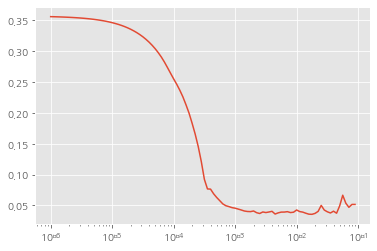

In [111]:
scheduling(model=model, X=X_train, y=y_train, epoch=100, batch_size=batch_size)

In [112]:
scheduled_train(model=model, X_train=X_train, y_train=y_train, epoch=800, batch_size=batch_size, lr=1e-03)

Train on 173 samples
Epoch 1/800
173/173 [==============================] - 3s 17ms/sample - loss: 0.0438 - mse: 0.0047
Epoch 2/800
173/173 [==============================] - 0s 323us/sample - loss: 0.0334 - mse: 0.0033
Epoch 3/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0298 - mse: 0.0028
Epoch 4/800
173/173 [==============================] - 0s 334us/sample - loss: 0.0291 - mse: 0.0027
Epoch 5/800
173/173 [==============================] - 0s 323us/sample - loss: 0.0280 - mse: 0.0026
Epoch 6/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0273 - mse: 0.0026
Epoch 7/800
173/173 [==============================] - 0s 352us/sample - loss: 0.0269 - mse: 0.0026
Epoch 8/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0266 - mse: 0.0026
Epoch 9/800
173/173 [==============================] - 0s 325us/sample - loss: 0.0264 - mse: 0.0026
Epoch 10/800
173/173 [==============================] - 0s 316us/sample - loss: 

173/173 [==============================] - 0s 490us/sample - loss: 0.0238 - mse: 0.0023
Epoch 82/800
173/173 [==============================] - 0s 386us/sample - loss: 0.0233 - mse: 0.0023
Epoch 83/800
173/173 [==============================] - 0s 340us/sample - loss: 0.0237 - mse: 0.0023
Epoch 84/800
173/173 [==============================] - 0s 346us/sample - loss: 0.0236 - mse: 0.0023
Epoch 85/800
173/173 [==============================] - 0s 323us/sample - loss: 0.0234 - mse: 0.0023
Epoch 86/800
173/173 [==============================] - 0s 311us/sample - loss: 0.0235 - mse: 0.0023
Epoch 87/800
173/173 [==============================] - 0s 334us/sample - loss: 0.0234 - mse: 0.0023
Epoch 88/800
173/173 [==============================] - 0s 340us/sample - loss: 0.0238 - mse: 0.0023
Epoch 89/800
173/173 [==============================] - 0s 369us/sample - loss: 0.0235 - mse: 0.0023
Epoch 90/800
173/173 [==============================] - 0s 340us/sample - loss: 0.0234 - mse: 0.0023
Epo

173/173 [==============================] - 0s 432us/sample - loss: 0.0222 - mse: 0.0021
Epoch 162/800
173/173 [==============================] - 0s 336us/sample - loss: 0.0221 - mse: 0.0021
Epoch 163/800
173/173 [==============================] - 0s 300us/sample - loss: 0.0224 - mse: 0.0021
Epoch 164/800
173/173 [==============================] - 0s 334us/sample - loss: 0.0225 - mse: 0.0022
Epoch 165/800
173/173 [==============================] - 0s 311us/sample - loss: 0.0229 - mse: 0.0022
Epoch 166/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0225 - mse: 0.0021
Epoch 167/800
173/173 [==============================] - 0s 306us/sample - loss: 0.0223 - mse: 0.0021
Epoch 168/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0222 - mse: 0.0021
Epoch 169/800
173/173 [==============================] - 0s 352us/sample - loss: 0.0221 - mse: 0.0021
Epoch 170/800
173/173 [==============================] - 0s 323us/sample - loss: 0.0222 - mse: 0

173/173 [==============================] - 0s 323us/sample - loss: 0.0214 - mse: 0.0020
Epoch 242/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0213 - mse: 0.0020
Epoch 243/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0211 - mse: 0.0019
Epoch 244/800
173/173 [==============================] - 0s 328us/sample - loss: 0.0213 - mse: 0.0020
Epoch 245/800
173/173 [==============================] - 0s 340us/sample - loss: 0.0211 - mse: 0.0019
Epoch 246/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0211 - mse: 0.0020
Epoch 247/800
173/173 [==============================] - ETA: 0s - loss: 0.0188 - mse: 0.001 - 0s 323us/sample - loss: 0.0213 - mse: 0.0020
Epoch 248/800
173/173 [==============================] - 0s 340us/sample - loss: 0.0214 - mse: 0.0019
Epoch 249/800
173/173 [==============================] - 0s 346us/sample - loss: 0.0210 - mse: 0.0020
Epoch 250/800
173/173 [==============================] - 0

173/173 [==============================] - 0s 306us/sample - loss: 0.0203 - mse: 0.0018
Epoch 321/800
173/173 [==============================] - 0s 387us/sample - loss: 0.0201 - mse: 0.0017
Epoch 322/800
173/173 [==============================] - 0s 392us/sample - loss: 0.0203 - mse: 0.0017
Epoch 323/800
173/173 [==============================] - 0s 346us/sample - loss: 0.0201 - mse: 0.0017
Epoch 324/800
173/173 [==============================] - 0s 314us/sample - loss: 0.0200 - mse: 0.0017
Epoch 325/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0201 - mse: 0.0017
Epoch 326/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0201 - mse: 0.0017
Epoch 327/800
173/173 [==============================] - 0s 335us/sample - loss: 0.0199 - mse: 0.0017
Epoch 328/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0200 - mse: 0.0017
Epoch 329/800
173/173 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.001 - 0

173/173 [==============================] - 0s 329us/sample - loss: 0.0190 - mse: 0.0015
Epoch 401/800
173/173 [==============================] - 0s 323us/sample - loss: 0.0189 - mse: 0.0015
Epoch 402/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0186 - mse: 0.0015
Epoch 403/800
173/173 [==============================] - 0s 352us/sample - loss: 0.0186 - mse: 0.0015
Epoch 404/800
173/173 [==============================] - 0s 377us/sample - loss: 0.0185 - mse: 0.0015
Epoch 405/800
173/173 [==============================] - 0s 345us/sample - loss: 0.0188 - mse: 0.0015
Epoch 406/800
173/173 [==============================] - 0s 380us/sample - loss: 0.0189 - mse: 0.0015
Epoch 407/800
173/173 [==============================] - 0s 478us/sample - loss: 0.0187 - mse: 0.0015
Epoch 408/800
173/173 [==============================] - 0s 502us/sample - loss: 0.0187 - mse: 0.0015
Epoch 409/800
173/173 [==============================] - 0s 473us/sample - loss: 0.0185 - mse: 0

173/173 [==============================] - 0s 311us/sample - loss: 0.0175 - mse: 0.0013
Epoch 481/800
173/173 [==============================] - 0s 347us/sample - loss: 0.0177 - mse: 0.0013
Epoch 482/800
173/173 [==============================] - 0s 311us/sample - loss: 0.0174 - mse: 0.0013
Epoch 483/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0176 - mse: 0.0014
Epoch 484/800
173/173 [==============================] - 0s 335us/sample - loss: 0.0171 - mse: 0.0013
Epoch 485/800
173/173 [==============================] - 0s 357us/sample - loss: 0.0171 - mse: 0.0013
Epoch 486/800
173/173 [==============================] - 0s 350us/sample - loss: 0.0173 - mse: 0.0013
Epoch 487/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0174 - mse: 0.0013
Epoch 488/800
173/173 [==============================] - 0s 322us/sample - loss: 0.0174 - mse: 0.0013
Epoch 489/800
173/173 [==============================] - 0s 314us/sample - loss: 0.0179 - mse: 0

173/173 [==============================] - 0s 334us/sample - loss: 0.0173 - mse: 0.0013
Epoch 561/800
173/173 [==============================] - 0s 297us/sample - loss: 0.0169 - mse: 0.0013
Epoch 562/800
173/173 [==============================] - ETA: 0s - loss: 0.0177 - mse: 0.001 - 0s 352us/sample - loss: 0.0168 - mse: 0.0012
Epoch 563/800
173/173 [==============================] - 0s 386us/sample - loss: 0.0166 - mse: 0.0012
Epoch 564/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0163 - mse: 0.0012
Epoch 565/800
173/173 [==============================] - 0s 380us/sample - loss: 0.0168 - mse: 0.0013
Epoch 566/800
173/173 [==============================] - 0s 341us/sample - loss: 0.0160 - mse: 0.0012
Epoch 567/800
173/173 [==============================] - 0s 398us/sample - loss: 0.0163 - mse: 0.0012
Epoch 568/800
173/173 [==============================] - 0s 519us/sample - loss: 0.0162 - mse: 0.0012
Epoch 569/800
173/173 [==============================] - 0

173/173 [==============================] - 0s 363us/sample - loss: 0.0156 - mse: 0.0011
Epoch 641/800
173/173 [==============================] - 0s 346us/sample - loss: 0.0158 - mse: 0.0011
Epoch 642/800
173/173 [==============================] - 0s 328us/sample - loss: 0.0153 - mse: 0.0011
Epoch 643/800
173/173 [==============================] - 0s 380us/sample - loss: 0.0154 - mse: 0.0011
Epoch 644/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0153 - mse: 0.0012
Epoch 645/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0159 - mse: 0.0011
Epoch 646/800
173/173 [==============================] - 0s 318us/sample - loss: 0.0154 - mse: 0.0011
Epoch 647/800
173/173 [==============================] - 0s 334us/sample - loss: 0.0153 - mse: 0.0011
Epoch 648/800
173/173 [==============================] - 0s 317us/sample - loss: 0.0154 - mse: 0.0011
Epoch 649/800
173/173 [==============================] - 0s 329us/sample - loss: 0.0154 - mse: 0

173/173 [==============================] - 0s 317us/sample - loss: 0.0147 - mse: 0.0011
Epoch 721/800
173/173 [==============================] - 0s 300us/sample - loss: 0.0147 - mse: 0.0011
Epoch 722/800
173/173 [==============================] - 0s 300us/sample - loss: 0.0143 - mse: 0.0011
Epoch 723/800
173/173 [==============================] - 0s 306us/sample - loss: 0.0148 - mse: 0.0011
Epoch 724/800
173/173 [==============================] - 0s 306us/sample - loss: 0.0151 - mse: 0.0011
Epoch 725/800
173/173 [==============================] - 0s 311us/sample - loss: 0.0148 - mse: 0.0011
Epoch 726/800
173/173 [==============================] - 0s 363us/sample - loss: 0.0150 - mse: 0.0011
Epoch 727/800
173/173 [==============================] - 0s 352us/sample - loss: 0.0147 - mse: 0.0011
Epoch 728/800
173/173 [==============================] - 0s 340us/sample - loss: 0.0151 - mse: 0.0010
Epoch 729/800
173/173 [==============================] - 0s 300us/sample - loss: 0.0150 - mse: 0

173/173 [==============================] - 0s 329us/sample - loss: 0.0138 - mse: 9.9554e-04


In [116]:
y_test_df = y_test.reshape(test_size, feature_size)
y_test_df = pd.DataFrame(y_test_df, columns = Data_norm.columns)
y_test_df.index = y_naive.index

y_hat = model.predict(X_test)
y_hat = y_hat.reshape(test_size, feature_size)
y_hat = pd.DataFrame(y_hat, columns = Data_norm.columns)
y_hat.index = y_naive.index

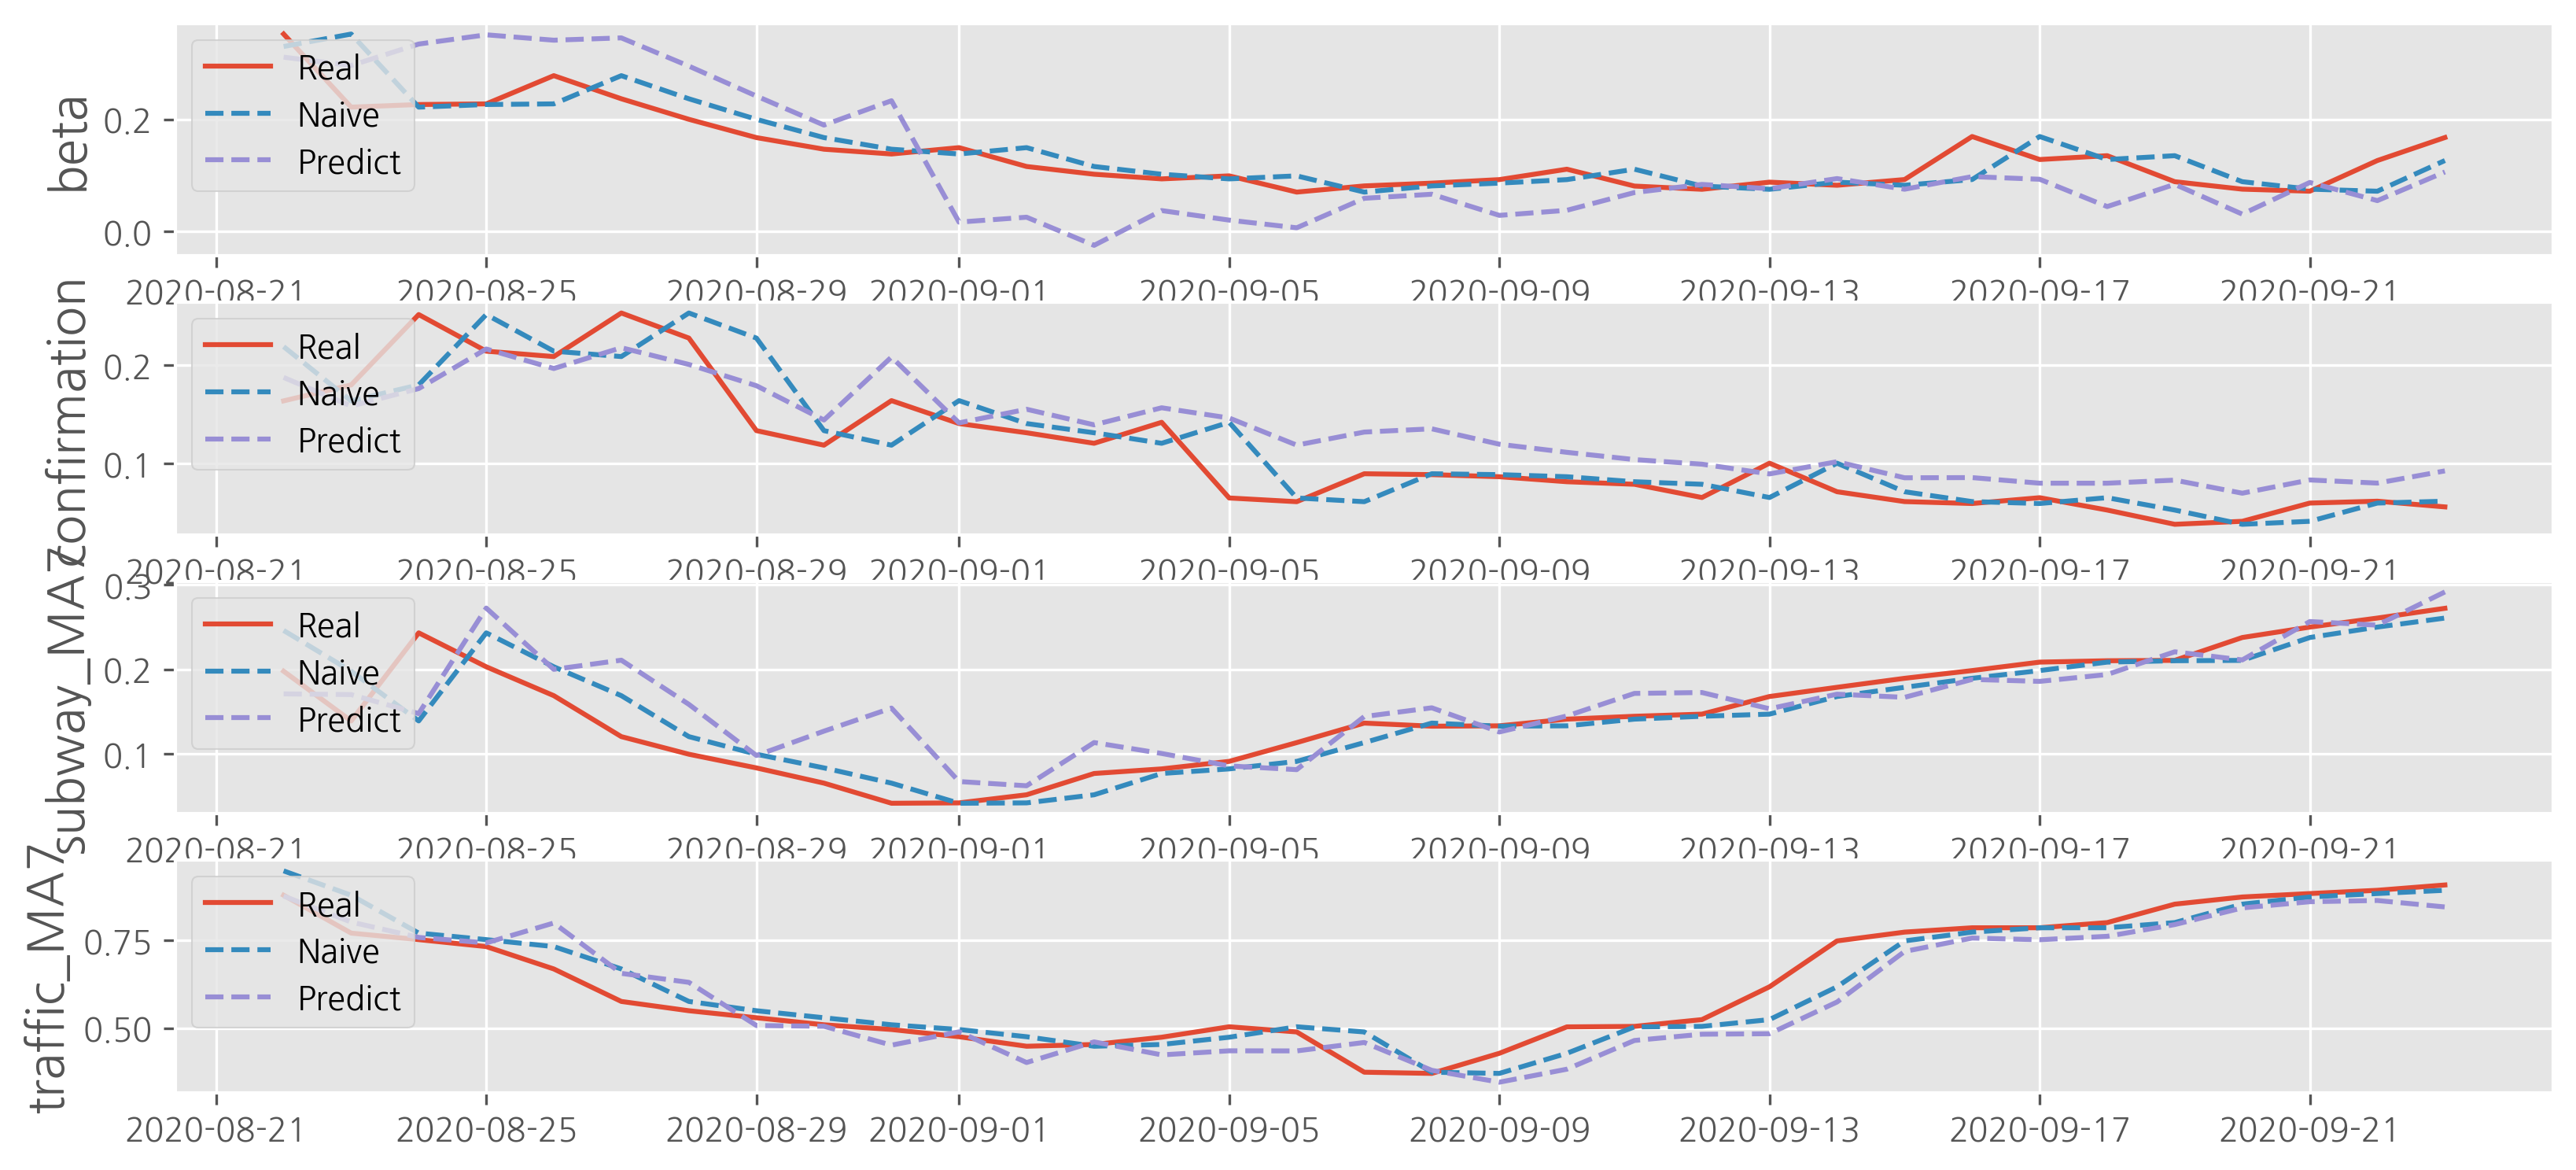

In [117]:
predplot(y_test_df=y_test_df, y_naive=y_naive, y_hat=y_hat, feature_size=feature_size)

In [118]:
error_mat(y_test_df=y_test_df, y_naive=y_naive, y_hat=y_hat)

               beta  confirmation  subway_MA7  traffic_MA7
naive      0.001318      0.001055    0.000824     0.002628
predicted  0.005078      0.001236    0.001611     0.004301


In [119]:
to_predict = pd.date_range(start='20200924', end='20201005')
days = len(to_predict)

In [120]:
for i in range(len(to_predict)):
    features = Data_norm.iloc[-days-window_size+i:-days+i].to_numpy()
    features = features.reshape(1, window_size, feature_size)
    predicted = model.predict(features)
    predicted = predicted.reshape(1, feature_size)
    Data_norm.iloc[-days+i, 0] = predicted[0, 0]

In [121]:
Beta_predicted = minbeta + Data_norm['beta']*(maxbeta-minbeta)
Beta_predicted = pd.DataFrame(Beta_predicted, columns = ['beta'])
Beta_predicted

,beta
2020-02-17,-0.006672
2020-02-18,0.125000
2020-02-19,0.405466
2020-02-20,0.264811
2020-02-21,0.269723
...,...
2020-10-01,0.002012
2020-10-02,0.066991
2020-10-03,-0.001769
2020-10-04,0.050382


## B) 감마 예측 모델

#### Data preprocessing

In [84]:
data_normal=pd.read_csv('Data_normal.csv')

In [85]:
data_normal.index=data_normal['Unnamed: 0']
data_normal.index.name=None
data_normal.drop(['Unnamed: 0'], axis=1, inplace=True)


gamma_normal=data_normal.loc['2020-02-17':, 'gamma']
time_range=pd.date_range('2020-02-17', periods=220)
gamma_normal=pd.DataFrame(data=gamma_normal, columns=['gamma'])
gamma_normal=gamma_normal.dropna()
gamma_normal

,gamma
2020-02-17,0.111111
2020-02-18,0.125000
2020-02-19,0.000000
2020-02-20,0.041667
2020-02-21,0.033333
...,...
2020-09-19,0.077300
2020-09-20,0.039954
2020-09-21,0.086957
2020-09-22,0.087763


In [86]:
gamma_X, gamma_Y=generateX(gamma_normal['gamma'], 7)
gamma_X=gamma_X.reshape(-1, 7, 1)
gamma_Y=gamma_Y.reshape(-1, 1)
print(gamma_X.shape)
print(gamma_Y.shape)

(213, 7, 1)
(213, 1)


In [87]:
r_X_train=gamma_X[:150, :,:]
r_y_train=gamma_Y[:150,:]
r_X_test=gamma_X[150:, :,:]
r_y_test=gamma_Y[150:,:]
 
print(r_X_train.shape)
print(r_y_train.shape)
print(r_X_test.shape)
print(r_y_test.shape)

(150, 7, 1)
(150, 1)
(63, 7, 1)
(63, 1)


#### Lstm모델 생성 및 예측

In [88]:
model_lstm_r=Sequential()
model_lstm_r.add(Bidirectional(LSTM(500,return_sequences=True, input_shape=(7 ,1))))
model_lstm_r.add(Bidirectional(LSTM(500,return_sequences=True)))
model_lstm_r.add(LSTM(500, activation='sigmoid'))
model_lstm_r.add(Dense(1))

adam=optimizers.Adam(lr=0.0001)

model_lstm_r.compile(loss='mean_squared_error', optimizer='adam')

In [89]:
model_lstm_r.fit(r_X_train, r_y_train, epochs=200, verbose=1)

Train on 150 samples
Epoch 1/200
150/150 [==============================] - 15s 102ms/sample - loss: 0.6567
Epoch 2/200
150/150 [==============================] - 3s 17ms/sample - loss: 0.2432
Epoch 3/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.1128
Epoch 4/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0703
Epoch 5/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0191
Epoch 6/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0037
Epoch 7/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0023
Epoch 8/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0016
Epoch 9/200
150/150 [==============================] - 2s 15ms/sample - loss: 0.0017
Epoch 10/200
150/150 [==============================] - 2s 14ms/sample - loss: 0.0016
Epoch 11/200
150/150 [==============================] - 2s 15ms/sample - loss: 0.0017
Epoch 12/200
150/150 [==================

150/150 [==============================] - 2s 16ms/sample - loss: 6.5962e-04
Epoch 93/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.5162e-04
Epoch 94/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.6061e-04
Epoch 95/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.5418e-04
Epoch 96/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.5240e-04
Epoch 97/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.9498e-04
Epoch 98/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.5183e-04
Epoch 99/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.6829e-04
Epoch 100/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.5357e-04
Epoch 101/200
150/150 [==============================] - 2s 16ms/sample - loss: 7.1741e-04
Epoch 102/200
150/150 [==============================] - 2s 16ms/sample - loss: 7.1663e-04
Epoch 103/200
150/15

150/150 [==============================] - 2s 16ms/sample - loss: 8.2602e-04
Epoch 183/200
150/150 [==============================] - 2s 16ms/sample - loss: 9.6774e-04
Epoch 184/200
150/150 [==============================] - 2s 16ms/sample - loss: 8.9288e-04
Epoch 185/200
150/150 [==============================] - 2s 16ms/sample - loss: 8.9474e-04
Epoch 186/200
150/150 [==============================] - 2s 16ms/sample - loss: 8.2382e-04
Epoch 187/200
150/150 [==============================] - 2s 16ms/sample - loss: 6.8548e-04
Epoch 188/200
150/150 [==============================] - 2s 16ms/sample - loss: 8.6314e-04
Epoch 189/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0010
Epoch 190/200
150/150 [==============================] - 2s 17ms/sample - loss: 0.0010
Epoch 191/200
150/150 [==============================] - 2s 16ms/sample - loss: 0.0011
Epoch 192/200
150/150 [==============================] - 2s 15ms/sample - loss: 8.0865e-04
Epoch 193/200
150/150 [==

In [124]:
r_y_pred_lstm=model_lstm_r.predict(r_X_test)

In [125]:
predict_range=pd.date_range('2020-07-23', periods=63)
r_lstm_predict=pd.DataFrame(index=predict_range, columns=['actual_gamma', 'predicted_gamma'])
r_lstm_predict['actual_gamma']=r_y_test
r_lstm_predict['predicted_gamma']=r_y_pred_lstm
r_lstm_predict

,actual_gamma,predicted_gamma
2020-07-23,0.052632,0.072334
2020-07-24,0.053985,0.063527
2020-07-25,0.033079,0.062057
2020-07-26,0.022843,0.053787
2020-07-27,0.057500,0.048331
...,...,...
2020-09-19,0.077300,0.083464
2020-09-20,0.039954,0.082031
2020-09-21,0.086957,0.066895
2020-09-22,0.087763,0.078967


Text(0, 0.5, 'gamma')

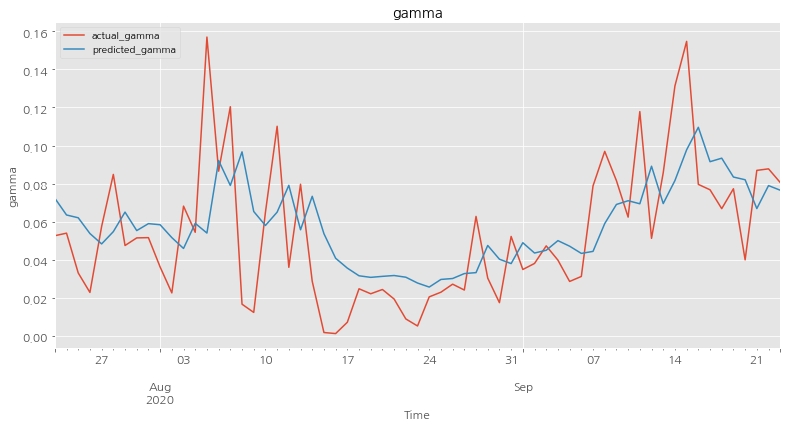

In [126]:
r_lstm_plot = r_lstm_predict[['actual_gamma', 'predicted_gamma']].plot(kind='line', title='gamma', figsize=(13, 6), legend=True, fontsize=12)
r_lstm_plot.set_xlabel('Time', fontsize=12)    
r_lstm_plot.set_ylabel('gamma', fontsize=12)

In [127]:
gamma_mse=model_lstm_r.evaluate(r_X_test, r_y_test, verbose=1)
gamma_mse

63/63 [==============================] - 1s 10ms/sample - loss: 9.4493e-04


0.0009449338900767977

# 2-3) Prediction

### A) beta 예측

In [147]:
beta_with_constraint=pd.read_csv('Beta_predicted_withConstraint.csv')
beta_with_constraint.index = pd.date_range(start='20200217', end='20201005')
beta_with_constraint=beta_with_constraint.loc['2020-09-01':, 'beta']
beta_with_constraint

2020-09-01    0.054979
2020-09-02    0.041112
2020-09-03    0.035419
2020-09-04    0.031987
2020-09-05    0.034217
2020-09-06    0.022283
2020-09-07    0.026826
2020-09-08    0.028874
2020-09-09    0.031464
2020-09-10    0.039117
2020-09-11    0.026719
2020-09-12    0.024341
2020-09-13    0.029595
2020-09-14    0.027304
2020-09-15    0.031515
2020-09-16    0.063154
2020-09-17    0.046236
2020-09-18    0.049059
2020-09-19    0.029936
2020-09-20    0.024433
2020-09-21    0.022929
2020-09-22    0.045489
2020-09-23    0.062400
2020-09-24    0.051703
2020-09-25    0.042015
2020-09-26    0.038416
2020-09-27    0.040614
2020-09-28    0.043892
2020-09-29    0.046497
2020-09-30    0.048519
2020-10-01    0.046846
2020-10-02    0.047882
2020-10-03    0.054153
2020-10-04    0.051998
2020-10-05    0.049686
Freq: D, Name: beta, dtype: float64

### B) gamma 예측

In [128]:
r_y_pred_lstm=r_y_pred_lstm.reshape(63, 1)
r_y_pred_lstm=pd.DataFrame(data=r_y_pred_lstm, columns=['gamma'])
gamma_pred_lstm= future_pred(data=gamma_normal, window_size=7, 
                    feature_size=1, days_to_predict=12, y_hat=r_y_pred_lstm, model=model_lstm_r)

C:\Users\hnn02\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [129]:
predict_range=pd.date_range('2020-07-23', periods=75)
gamma_pred_lstm=gamma_pred_lstm.set_index(predict_range)

In [130]:
gamma_new=gamma_pred_lstm.loc['2020-09-01':, 'gamma']
gamma_new

2020-09-01    0.048952
2020-09-02    0.043540
2020-09-03    0.044988
2020-09-04    0.050049
2020-09-05    0.047132
2020-09-06    0.043345
2020-09-07    0.044410
2020-09-08    0.059031
2020-09-09    0.069056
2020-09-10    0.071014
2020-09-11    0.069416
2020-09-12    0.089140
2020-09-13    0.069523
2020-09-14    0.081601
2020-09-15    0.097752
2020-09-16    0.109580
2020-09-17    0.091515
2020-09-18    0.093361
2020-09-19    0.083464
2020-09-20    0.082031
2020-09-21    0.066895
2020-09-22    0.078967
2020-09-23    0.076534
2020-09-24    0.076200
2020-09-25    0.076684
2020-09-26    0.077689
2020-09-27    0.076491
2020-09-28    0.077371
2020-09-29    0.077352
2020-09-30    0.077003
2020-10-01    0.076748
2020-10-02    0.076693
2020-10-03    0.076665
2020-10-04    0.076555
2020-10-05    0.076498
Freq: D, Name: gamma, dtype: float32

### C) SIR 모델을 통한 확진자 예측

+ 위에서 구한 베타와 감마를 SIR모델에 넣어 추석기간내 확진자를 예측해보자!

In [148]:
def deriv_sir(y, t, n, beta, gamma):
    s, i, r = y
    dsdt = (-beta * s * i)/ n
    didt = (beta * s * i)/n - gamma * i
    drdt = gamma * i
    return dsdt, didt, drdt

In [149]:
s0= 26014428
i0= 3553
r0= 4471

In [150]:
t=range(35)
beta=beta_with_constraint
gamma=gamma_new

In [151]:
res=np.zeros((len(t), 3))
res[0,:]=(s0, i0, r0)

for i in range(len(t)-1):
    ts=[t[i], t[i+1]]
    res_tmp = odeint(deriv_sir,(s0, i0, r0), ts, args=(26022452, beta[i], gamma[i]))
    s0=res_tmp[1,0]
    i0=res_tmp[1,1]
    r0=res_tmp[1,2]
    res[i+1,:]=(s0, i0, r0)

In [152]:
I_acu=data_normal.loc['2020-09-01':, 'Infectious']
R_acu=data_normal.loc['2020-09-01':, 'Recovery']
total_actual=I_acu+R_acu
total_pred=res[:,1]+res[:,2]

In [153]:
plot_IR(name='I & R', t=t,  i_actual=I_acu, r_actual=R_acu, i_pred=res[:,1], r_pred=res[:,2])

In [154]:
plot_total_case(name='누적확진자', t=t,  total_actual=total_actual, total_pred=total_pred)

# 3) Results

In [155]:
predict_range=pd.date_range('2020-09-01', periods=35)
total_pred=pd.DataFrame(index=predict_range, columns=['누적 확진자 수'], data=total_pred)
total_pred

,누적 확진자 수
2020-09-01,8024.000000
2020-09-02,8219.867537
2020-09-03,8366.592449
2020-09-04,8492.243922
2020-09-05,8604.159627
2020-09-06,8722.037444
2020-09-07,8797.507391
2020-09-08,8886.625176
2020-09-09,8980.283681
2020-09-10,9078.947078


In [156]:
total_pred_new=total_pred.copy()
for i in range(len(total_pred.index)-1):
    total_pred_new.iloc[i+1,0]=(total_pred.iloc[i+1,0]-total_pred.iloc[i,0])*0.514

In [157]:
total_pred_chusuk=total_pred_new.iloc[29:34]
total_pred_chusuk=total_pred_chusuk.rename(columns={'누적 확진자 수': '일별 확진자 수'})
total_pred_chusuk

,일별 확진자 수
2020-09-30,32.321984
2020-10-01,32.741034
2020-10-02,30.701786
2020-10-03,30.472067
2020-10-04,33.588903
